#Trainieren des GCN-Models für Loan-Datensatz Event-basiert 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM"

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2


In [ ]:
%%capture
!pip install dive-into-graphs

In [ ]:
%%capture
!pip install pm4py

In [ ]:
import torch
import joblib
import random
from torch_geometric.data import DataLoader
from models.gcn3_neu import *

# Module für das Preprocessing der verwendeten Datensätze
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *
from train_gcn import train_model, create_splitted_dataloader, load_gcn_key

In [ ]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Datensatz laden

In [ ]:
dataset_name = "loan_all_events_fall_ohe_wEvents_5_2" # "loan_nreb_fall_ohe_wEvents_5_all"
dataset_list_review = torch.load(path / str("datasets/dataset_"+ dataset_name))
feature_list_review  = joblib.load("datasets/encoder_" + dataset_name + ".joblib")


## Model instantiieren

In [ ]:
def instantiate_model( num_feature, hidden_channel = 100, num_layer = 3):
  # GCN initialisieren
  # Model Variablen
 
  input_dim = num_feature
  gcn_model = GCN3(hidden_channel, input_dim, num_layer).to(device)
  return gcn_model

## Parameter Tuning

In [ ]:
from utilities_parameter_tuning import save_plots, save_hyperparam, create_run, run_tuning

### Ganzer Graph

In [ ]:
dataset = dataset_list_review[0]

<IPython.core.display.Javascript object>

-----------------lr: 0.05 ---------------------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_graph/run_1
save Hyperparameter
Epoch: 001, Train Acc: 0.8570, Validation Acc: 0.8493, Loss Training: 0.3244, Loss Validation: 0.3359
Epoch: 002, Train Acc: 0.8676, Validation Acc: 0.8598, Loss Training: 0.3158, Loss Validation: 0.3263
Epoch: 003, Train Acc: 0.8712, Validation Acc: 0.8637, Loss Training: 0.3286, Loss Validation: 0.3408
Epoch: 004, Train Acc: 0.8556, Validation Acc: 0.8465, Loss Training: 0.3545, Loss Validation: 0.3696
Epoch: 005, Train Acc: 0.8556, Validation Acc: 0.8465, Loss Training: 0.3544, Loss Validation: 0.3696
Epoch: 006, Train Acc: 0.8556, Validation Acc: 0.8465, Loss Training: 0.3544, Loss Validation: 0.3695
Epoch: 007, Train Acc: 0.8556, Validation Acc: 0.8465, Loss Training: 0.3544, Loss Validation: 0.3694
Epoch: 008, Train Acc: 0.8556, Validation Acc: 0.8465, Loss Training: 0.3543, Loss Validation: 0.

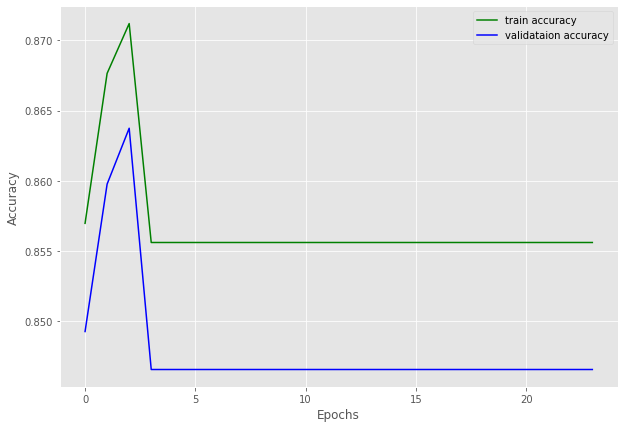

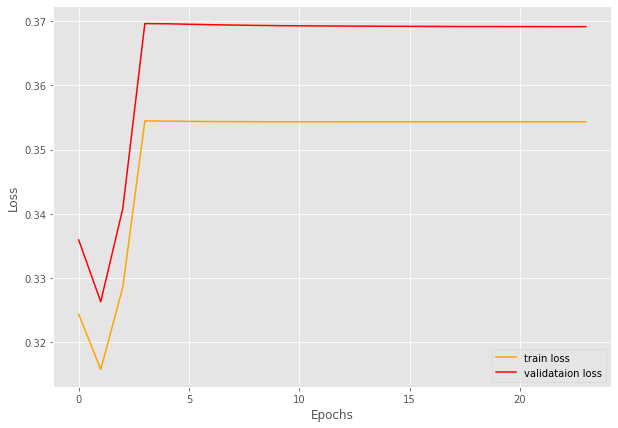

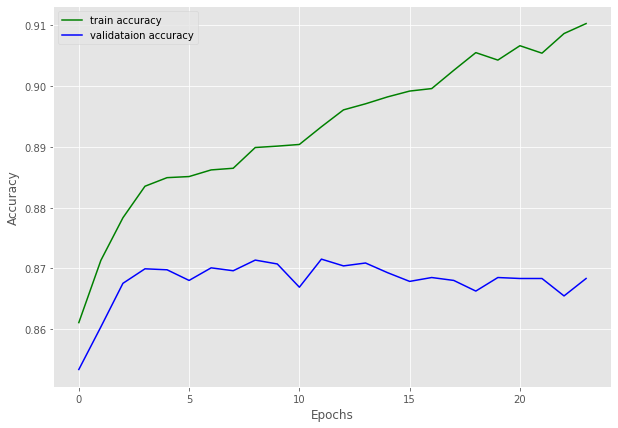

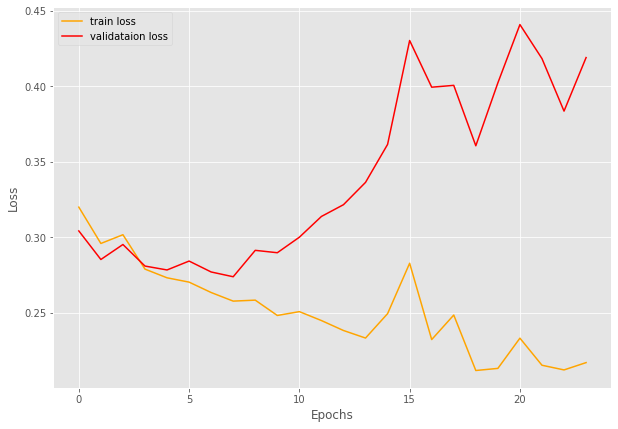

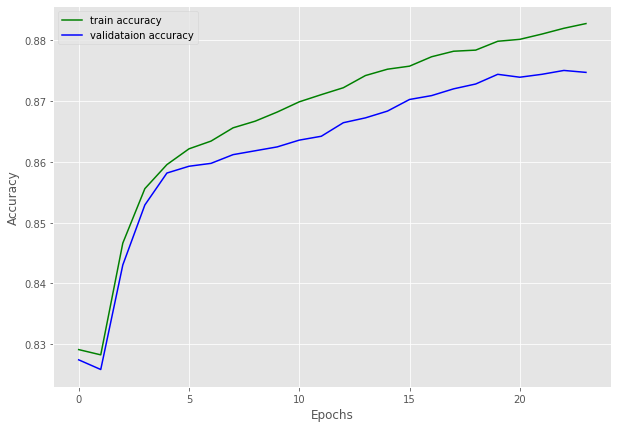

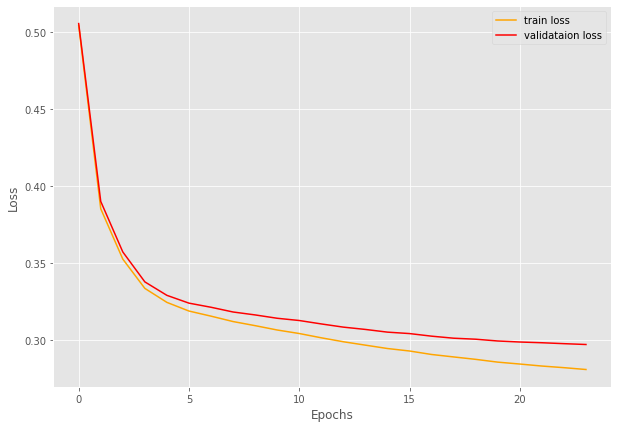

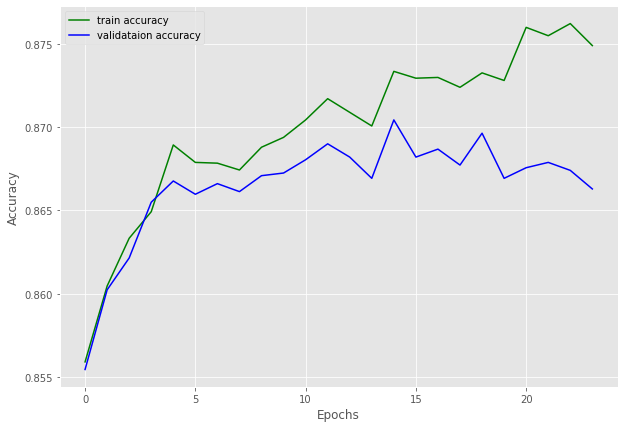

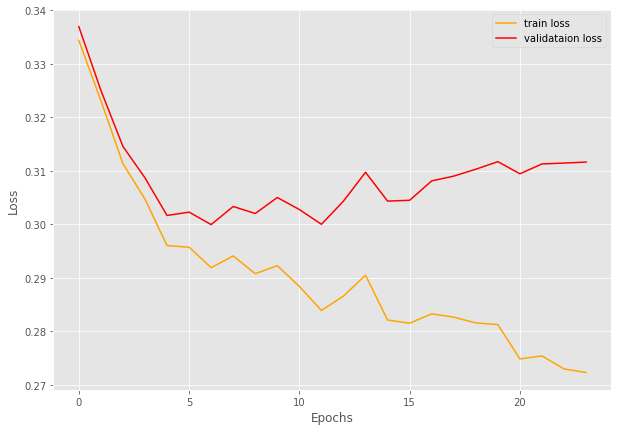

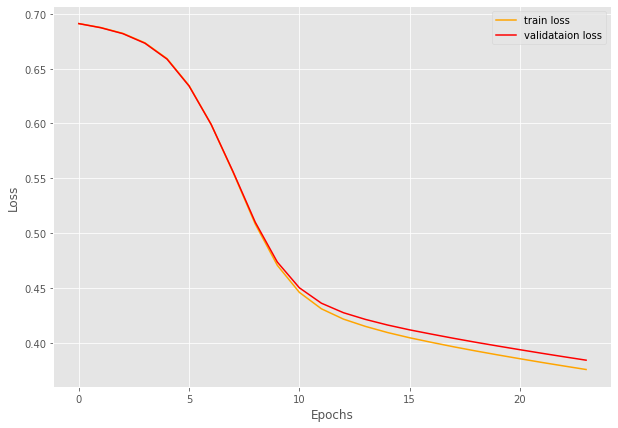

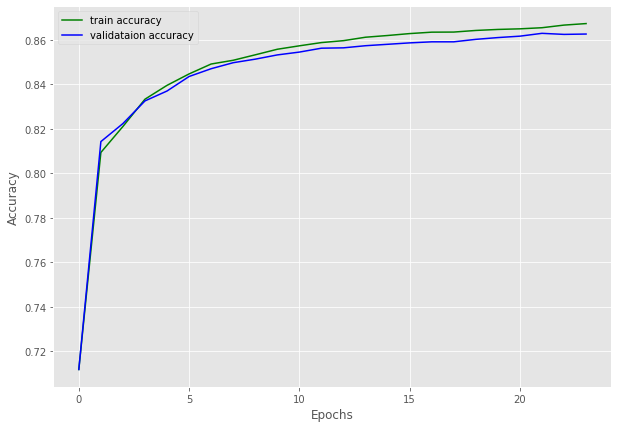

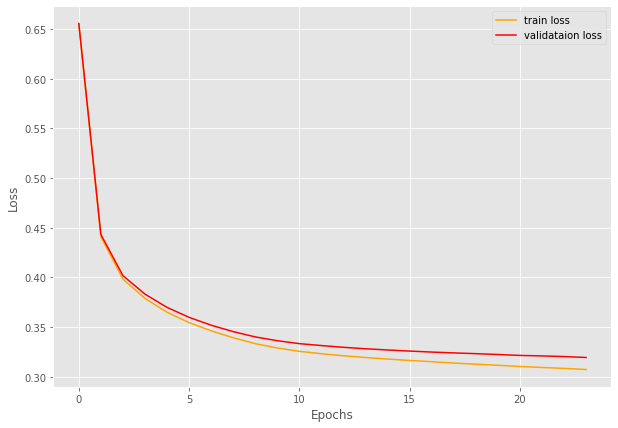

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for lr in [0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005]:
  print(f"-----------------lr: {lr} ---------------------------")
  # Variablen besetzen
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)
  #print(f"Feature-Anzahl: {num_feature}")

  #model
  gcn_model = instantiate_model(num_feature)  

  # tuning
  param = {"lr": lr, "num_epochs": 25}
  run_tuning(param, path, dataset_name + "_graph", gcn_model, device, train_loader, val_loader, test_loader)

### Präfixe

In [ ]:
# Ganzer Graph wird seperat trainiert
dataset_list_review.pop(0)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_1
save Hyperparameter
Epoch: 001, Train Acc: 0.5600, Validation Acc: 0.5430, Loss Training: 0.6816, Loss Validation: 0.6835
Epoch: 002, Train Acc: 0.5451, Validation Acc: 0.5532, Loss Training: 0.6821, Loss Validation: 0.6830
Epoch: 003, Train Acc: 0.5571, Validation Acc: 0.5384, Loss Training: 0.6817, Loss Validation: 0.6832
Epoch: 004, Train Acc: 0.5604, Validation Acc: 0.5422, Loss Training: 0.6801, Loss Validation: 0.6819
Epoch: 005, Train Acc: 0.5604, Validation Acc: 0.5422, Loss Training: 0.6816, Loss Validation: 0.6834
Epoch: 006, Train Acc: 0.5604, Validation Acc: 0.5422, Loss Training: 0.6831, Loss Validation: 0.6845
Epoch: 007, Train Acc: 0.5451, Validation Acc: 0.5532, Loss Training: 0.6821, Loss Validation: 0.6832
Epoch: 008, Train Acc: 0.5604, Validation Acc: 0.5422, Loss Training: 0.6805, Loss Validation: 0.6825
Epoch: 009, Trai

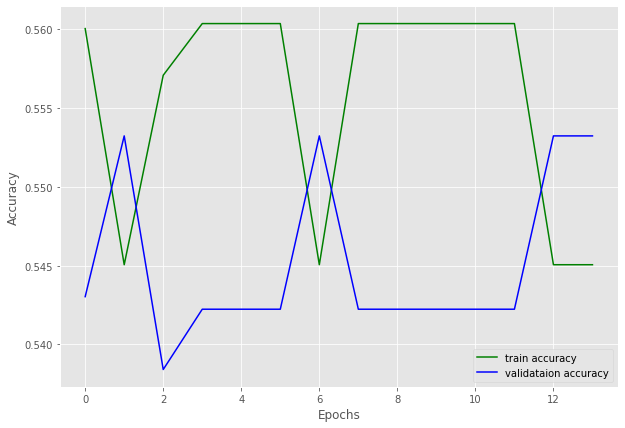

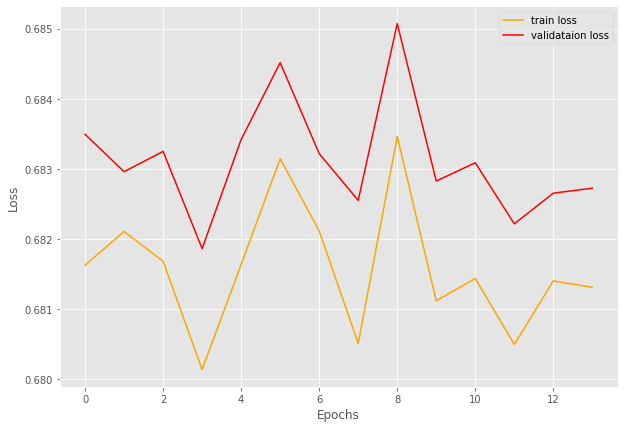

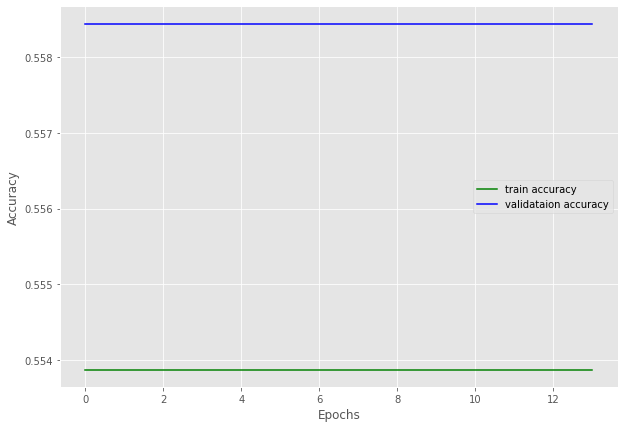

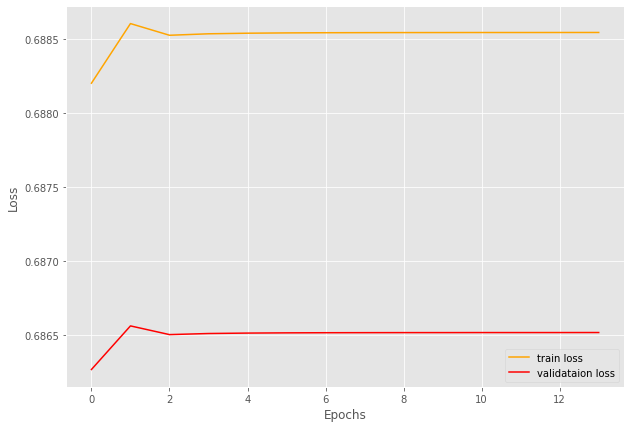

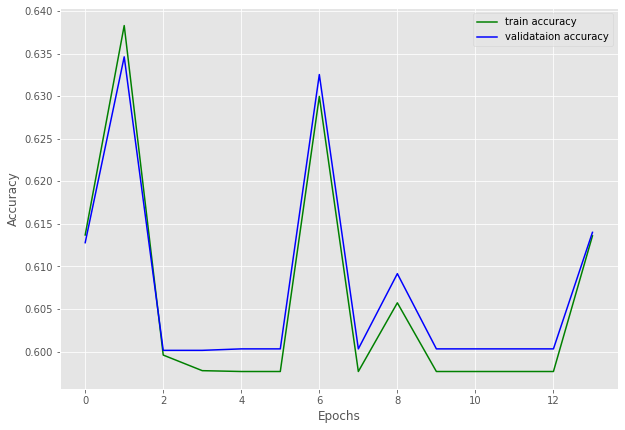

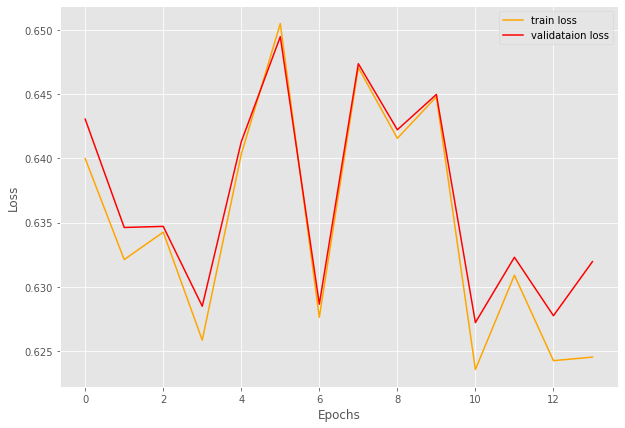

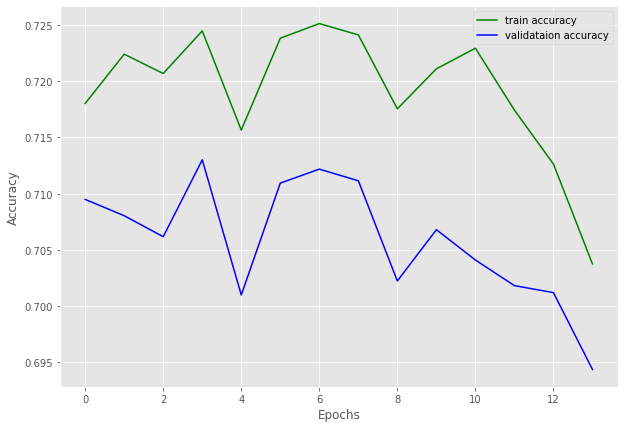

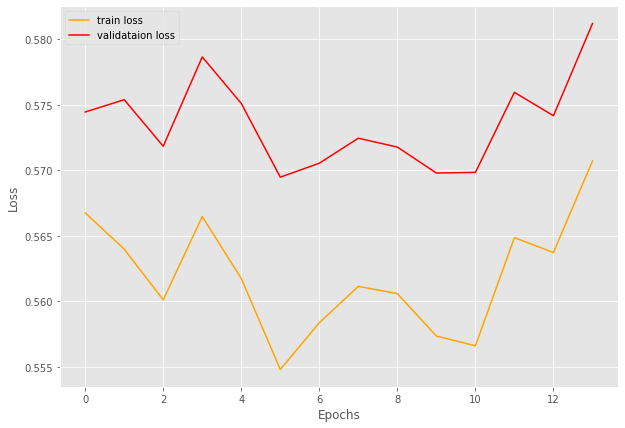

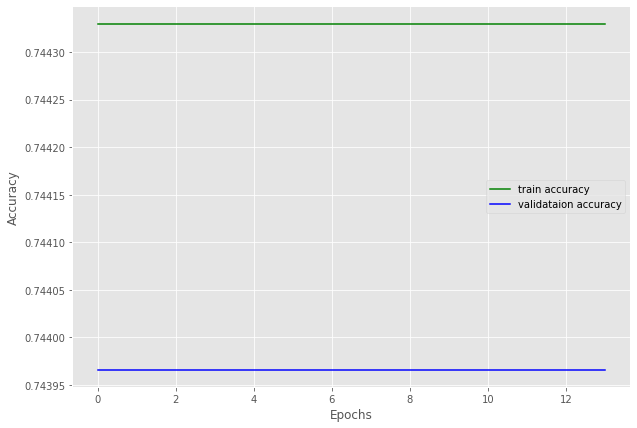

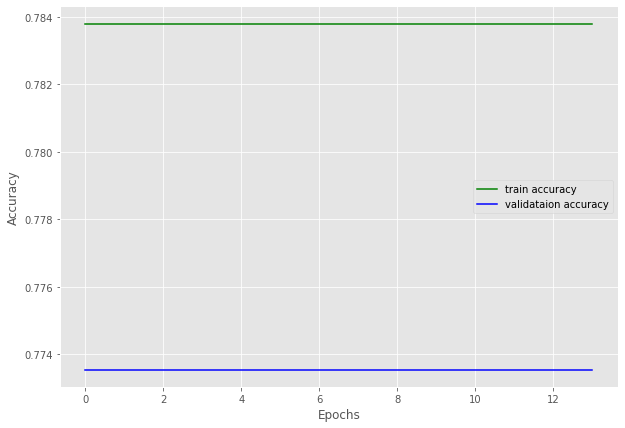

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)
  #print(f"Feature-Anzahl: {num_feature}")

  #model
  gcn_model = instantiate_model(num_feature)   

  # tuning
  param = {"lr": 0.05, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_2
save Hyperparameter
Epoch: 001, Train Acc: 0.5890, Validation Acc: 0.5767, Loss Training: 0.6689, Loss Validation: 0.6734
Epoch: 002, Train Acc: 0.5914, Validation Acc: 0.5885, Loss Training: 0.6655, Loss Validation: 0.6702
Epoch: 003, Train Acc: 0.5927, Validation Acc: 0.5792, Loss Training: 0.6637, Loss Validation: 0.6706
Epoch: 004, Train Acc: 0.5978, Validation Acc: 0.5835, Loss Training: 0.6618, Loss Validation: 0.6710
Epoch: 005, Train Acc: 0.5959, Validation Acc: 0.5810, Loss Training: 0.6597, Loss Validation: 0.6718
Epoch: 006, Train Acc: 0.6019, Validation Acc: 0.5813, Loss Training: 0.6578, Loss Validation: 0.6732
Epoch: 007, Train Acc: 0.6036, Validation Acc: 0.5819, Loss Training: 0.6559, Loss Validation: 0.6767
Epoch: 008, Train Acc: 0.5983, Validation Acc: 0.5735, Loss Training: 0.6575, Loss Validation: 0.6872
Epoch: 009, Trai

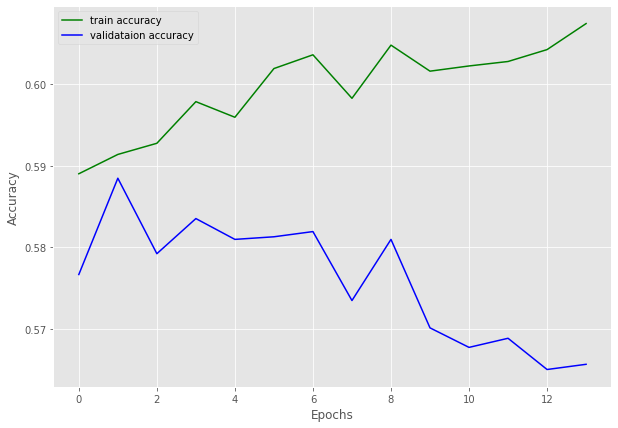

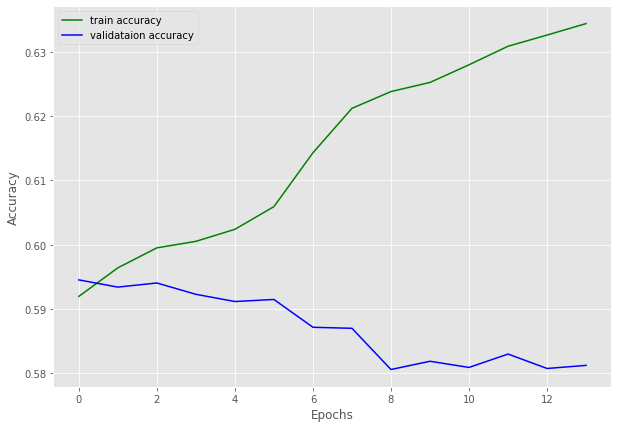

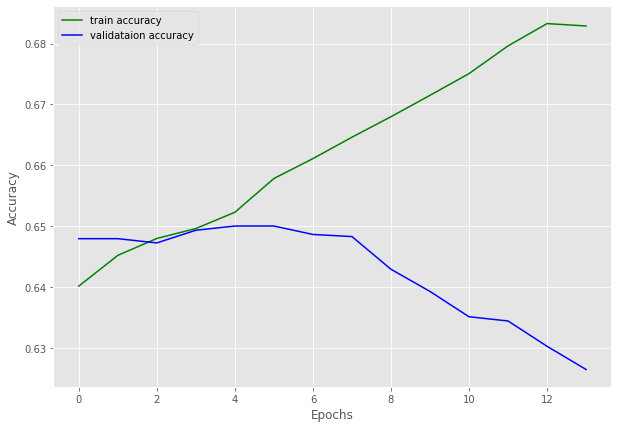

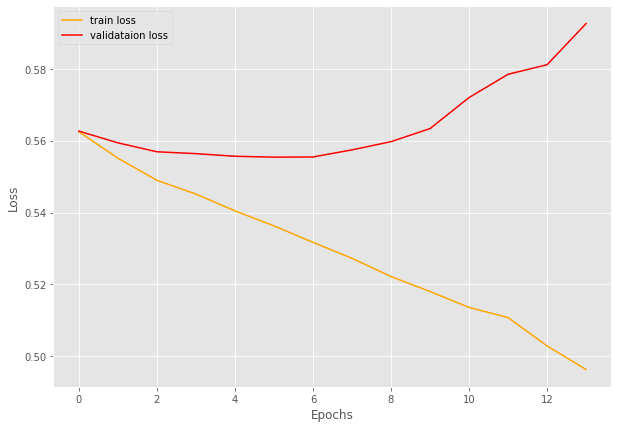

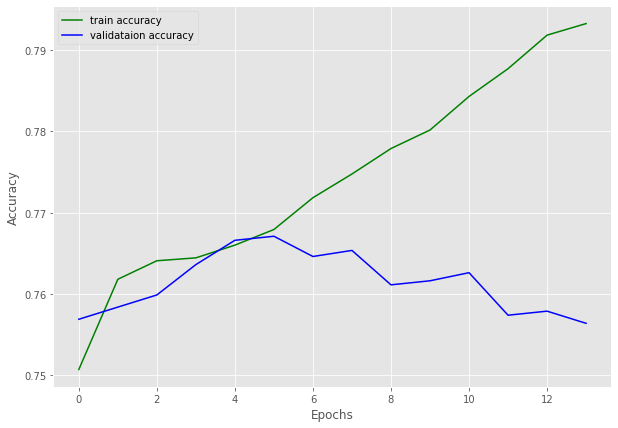

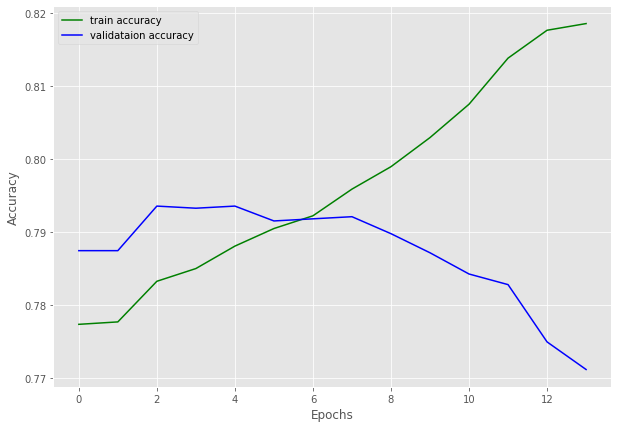

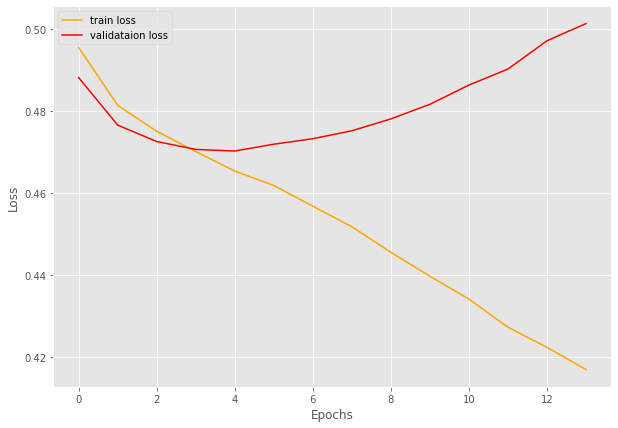

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)   

  # tuning
  param = {"lr": 0.001, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_3
save Hyperparameter
Epoch: 001, Train Acc: 0.5881, Validation Acc: 0.5783, Loss Training: 0.6665, Loss Validation: 0.6741
Epoch: 002, Train Acc: 0.5891, Validation Acc: 0.5768, Loss Training: 0.6646, Loss Validation: 0.6760
Epoch: 003, Train Acc: 0.5905, Validation Acc: 0.5755, Loss Training: 0.6644, Loss Validation: 0.6791
Epoch: 004, Train Acc: 0.5885, Validation Acc: 0.5700, Loss Training: 0.6664, Loss Validation: 0.6920
Epoch: 005, Train Acc: 0.5830, Validation Acc: 0.5658, Loss Training: 0.6644, Loss Validation: 0.6873
Epoch: 006, Train Acc: 0.5822, Validation Acc: 0.5615, Loss Training: 0.6714, Loss Validation: 0.6993
Epoch: 007, Train Acc: 0.5836, Validation Acc: 0.5617, Loss Training: 0.6683, Loss Validation: 0.7004
Epoch: 008, Train Acc: 0.5906, Validation Acc: 0.5682, Loss Training: 0.6660, Loss Validation: 0.7176
Epoch: 009, Trai

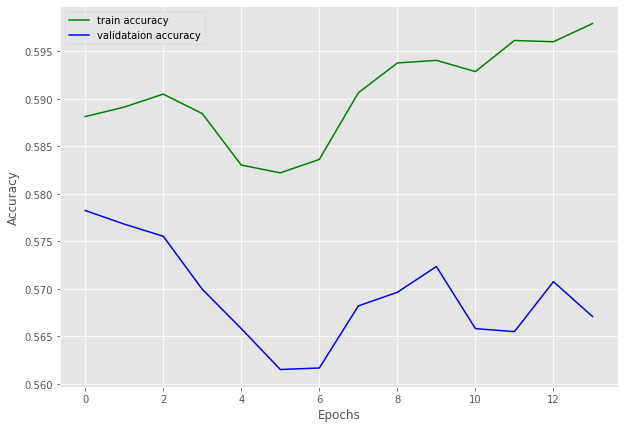

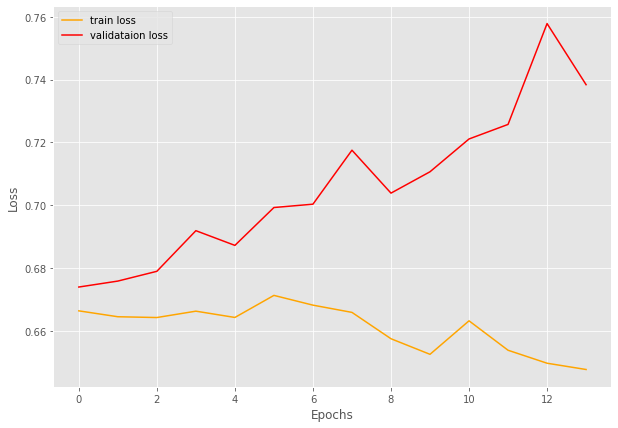

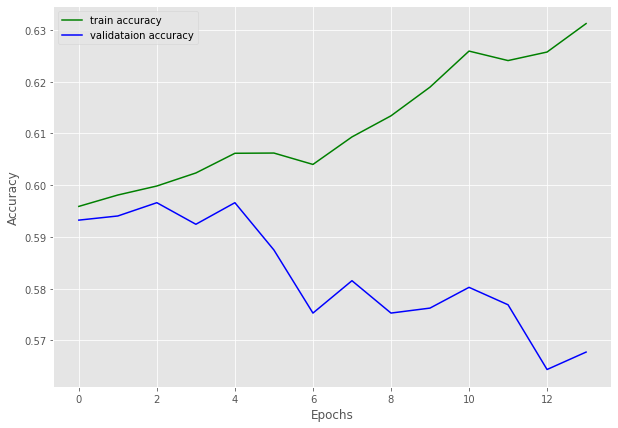

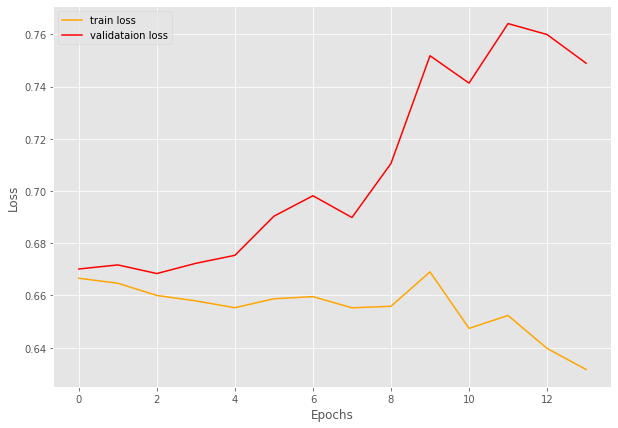

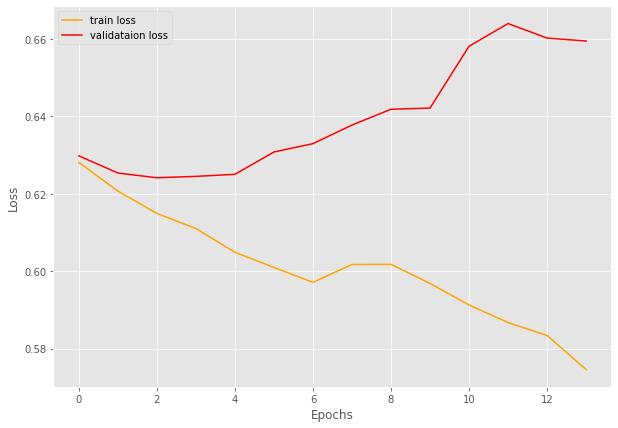

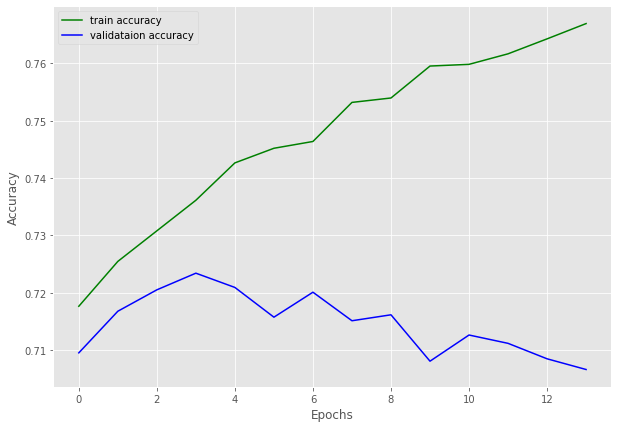

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)   
  param = {"lr": 0.005, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)   
  param = {"lr": 0.0001, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_4
save Hyperparameter
Epoch: 001, Train Acc: 0.5620, Validation Acc: 0.5690, Loss Training: 0.6773, Loss Validation: 0.6757
Epoch: 002, Train Acc: 0.5784, Validation Acc: 0.5877, Loss Training: 0.6746, Loss Validation: 0.6733
Epoch: 003, Train Acc: 0.5829, Validation Acc: 0.5904, Loss Training: 0.6729, Loss Validation: 0.6721
Epoch: 004, Train Acc: 0.5834, Validation Acc: 0.5907, Loss Training: 0.6713, Loss Validation: 0.6709
Epoch: 005, Train Acc: 0.5835, Validation Acc: 0.5910, Loss Training: 0.6704, Loss Validation: 0.6703
Epoch: 006, Train Acc: 0.5834, Validation Acc: 0.5910, Loss Training: 0.6695, Loss Validation: 0.6700
Epoch: 007, Train Acc: 0.5847, Validation Acc: 0.5924, Loss Training: 0.6687, Loss Validation: 0.6699
Epoch: 008, Train Acc: 0.5832, Validation Acc: 0.5913, Loss Training: 0.6681, Loss Validation: 0.6699
Epoch: 009, Trai

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_5
save Hyperparameter
Epoch: 001, Train Acc: 0.5757, Validation Acc: 0.5744, Loss Training: 0.6722, Loss Validation: 0.6744
Epoch: 002, Train Acc: 0.5881, Validation Acc: 0.5795, Loss Training: 0.6687, Loss Validation: 0.6722
Epoch: 003, Train Acc: 0.5881, Validation Acc: 0.5797, Loss Training: 0.6673, Loss Validation: 0.6722
Epoch: 004, Train Acc: 0.5890, Validation Acc: 0.5791, Loss Training: 0.6660, Loss Validation: 0.6721
Epoch: 005, Train Acc: 0.5892, Validation Acc: 0.5786, Loss Training: 0.6645, Loss Validation: 0.6718
Epoch: 006, Train Acc: 0.5899, Validation Acc: 0.5784, Loss Training: 0.6633, Loss Validation: 0.6723
Epoch: 007, Train Acc: 0.5905, Validation Acc: 0.5791, Loss Training: 0.6624, Loss Validation: 0.6735
Epoch: 008, Train Acc: 0.5909, Validation Acc: 0.5789, Loss Training: 0.6612, Loss Validation: 0.6741
Epoch: 009, Trai

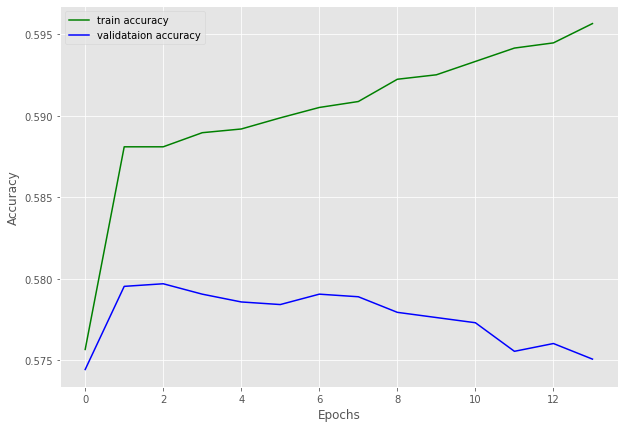

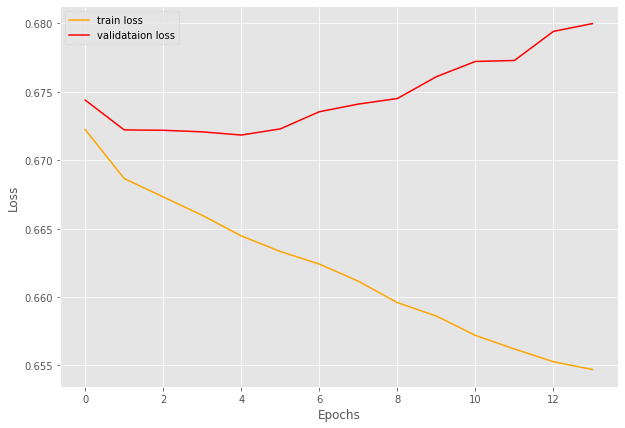

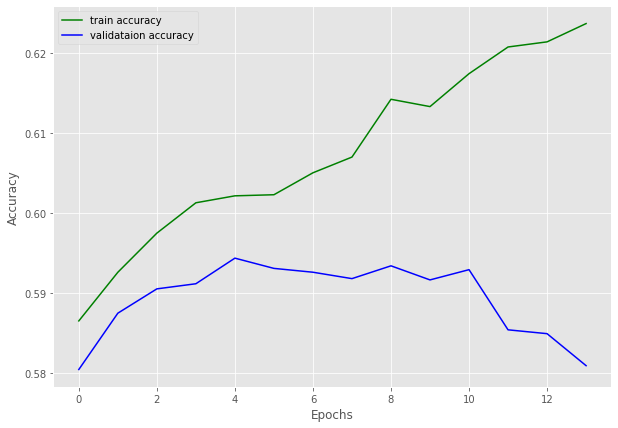

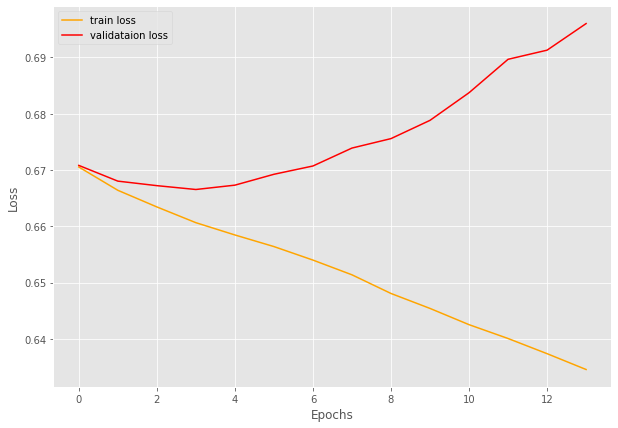

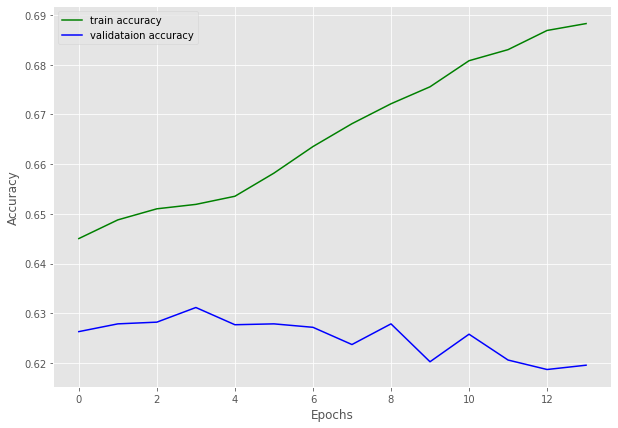

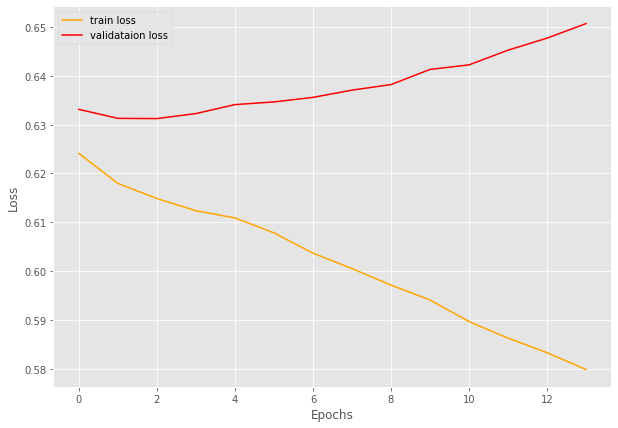

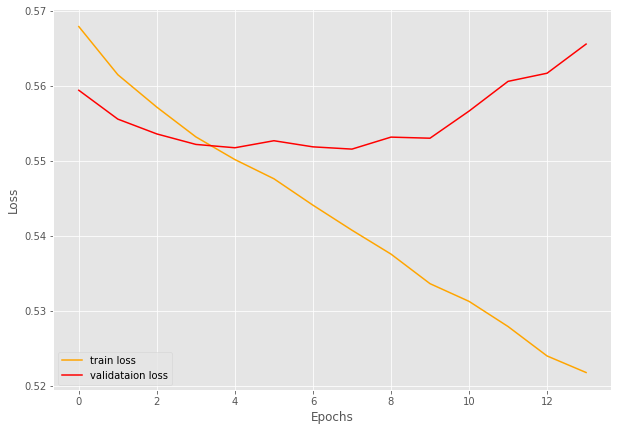

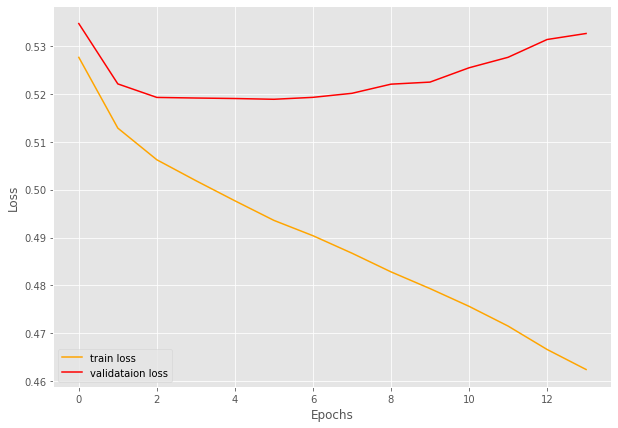

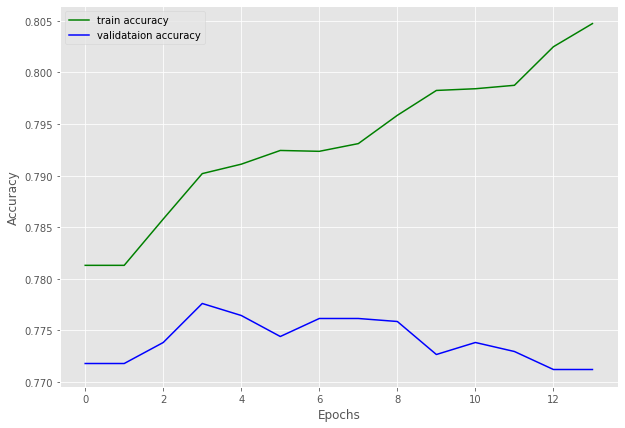

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)  
  param = {"lr": 0.0005, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_6
save Hyperparameter
Epoch: 001, Train Acc: 0.4812, Validation Acc: 0.4734, Loss Training: 0.6935, Loss Validation: 0.6936
Epoch: 002, Train Acc: 0.5473, Validation Acc: 0.5596, Loss Training: 0.6912, Loss Validation: 0.6908
Epoch: 003, Train Acc: 0.5473, Validation Acc: 0.5595, Loss Training: 0.6893, Loss Validation: 0.6885
Epoch: 004, Train Acc: 0.5473, Validation Acc: 0.5595, Loss Training: 0.6878, Loss Validation: 0.6865
Epoch: 005, Train Acc: 0.5473, Validation Acc: 0.5595, Loss Training: 0.6864, Loss Validation: 0.6848
Epoch: 006, Train Acc: 0.5473, Validation Acc: 0.5595, Loss Training: 0.6850, Loss Validation: 0.6832
Epoch: 007, Train Acc: 0.5473, Validation Acc: 0.5595, Loss Training: 0.6836, Loss Validation: 0.6816
Epoch: 008, Train Acc: 0.5473, Validation Acc: 0.5595, Loss Training: 0.6822, Loss Validation: 0.6800
Epoch: 009, Trai

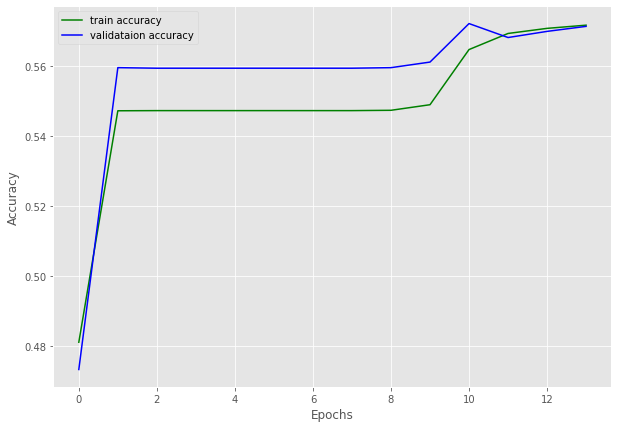

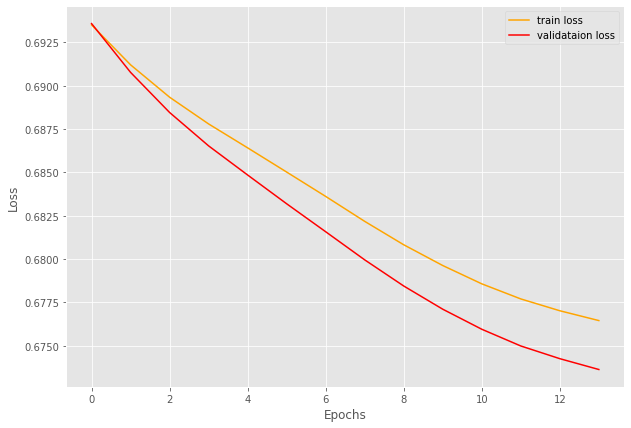

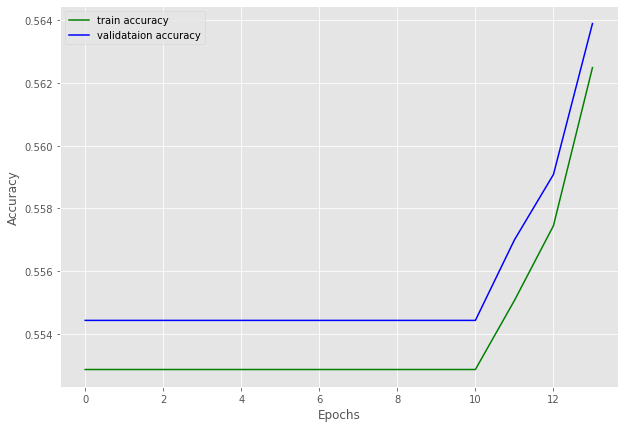

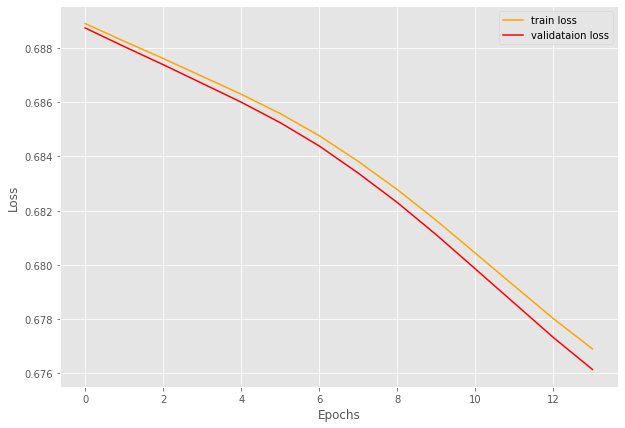

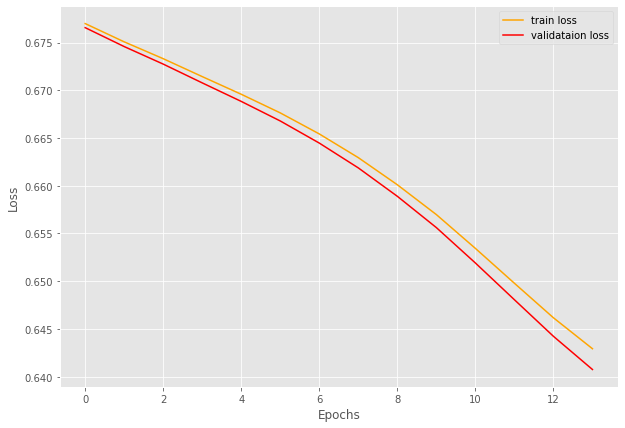

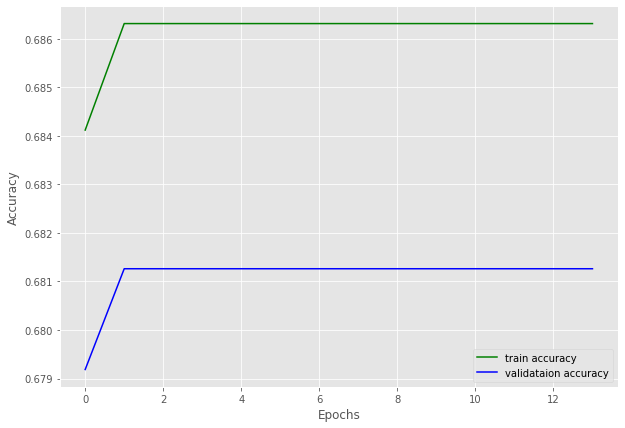

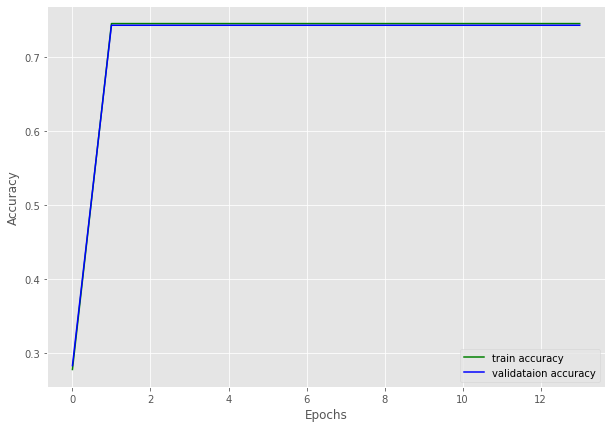

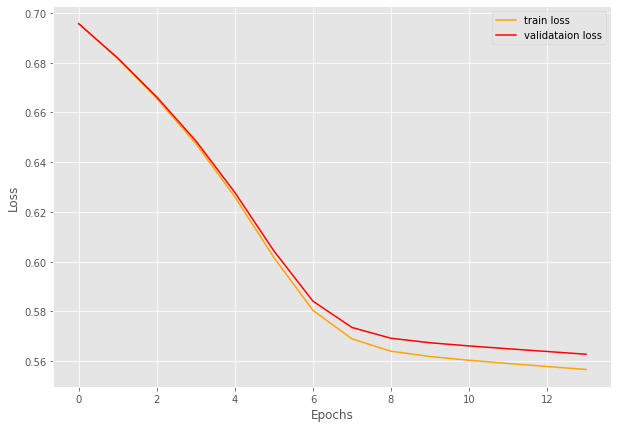

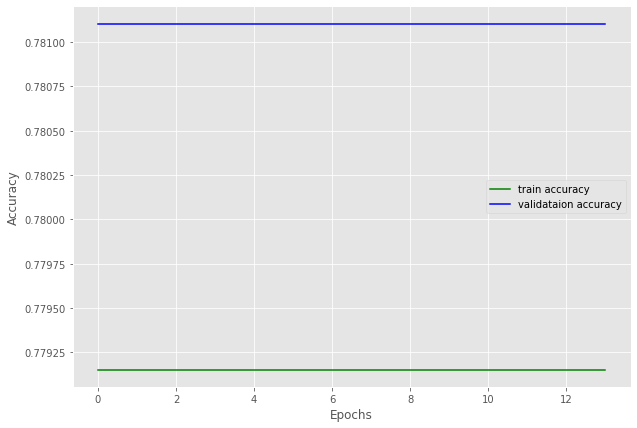

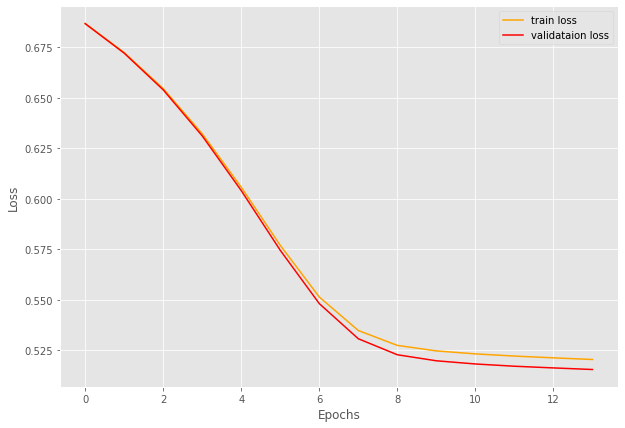

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)  
  param = {"lr": 0.00001, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_7
save Hyperparameter
Epoch: 001, Train Acc: 0.5488, Validation Acc: 0.5443, Loss Training: 0.6828, Loss Validation: 0.6834
Epoch: 002, Train Acc: 0.5488, Validation Acc: 0.5443, Loss Training: 0.6781, Loss Validation: 0.6784
Epoch: 003, Train Acc: 0.5671, Validation Acc: 0.5653, Loss Training: 0.6762, Loss Validation: 0.6766
Epoch: 004, Train Acc: 0.5717, Validation Acc: 0.5682, Loss Training: 0.6752, Loss Validation: 0.6758
Epoch: 005, Train Acc: 0.5764, Validation Acc: 0.5792, Loss Training: 0.6743, Loss Validation: 0.6753
Epoch: 006, Train Acc: 0.5796, Validation Acc: 0.5808, Loss Training: 0.6734, Loss Validation: 0.6748
Epoch: 007, Train Acc: 0.5811, Validation Acc: 0.5822, Loss Training: 0.6723, Loss Validation: 0.6741
Epoch: 008, Train Acc: 0.5844, Validation Acc: 0.5763, Loss Training: 0.6713, Loss Validation: 0.6738
Epoch: 009, Trai

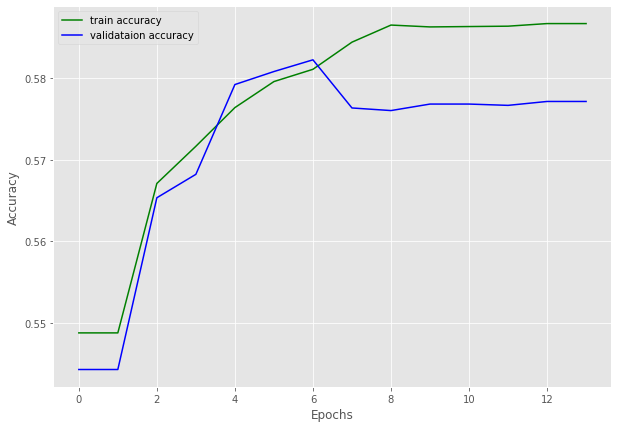

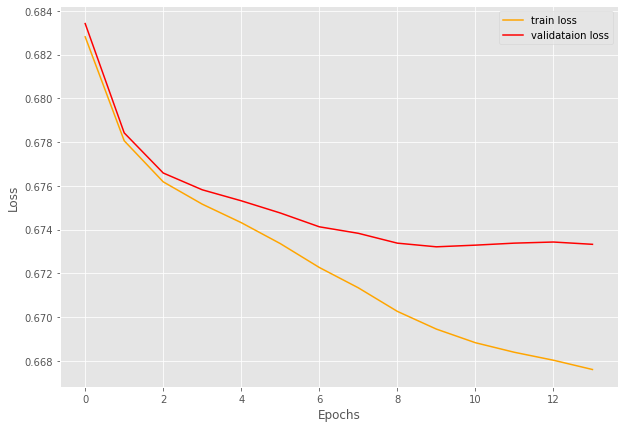

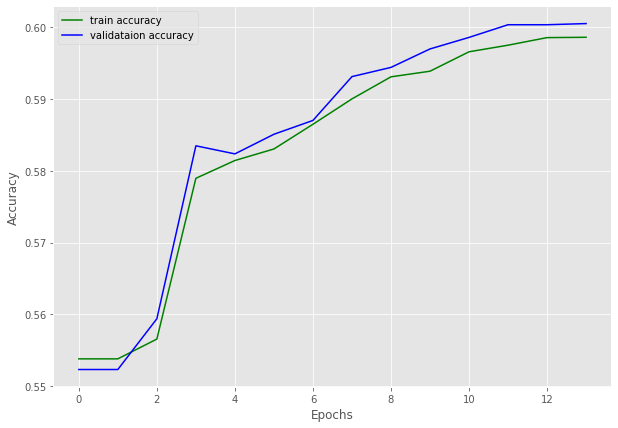

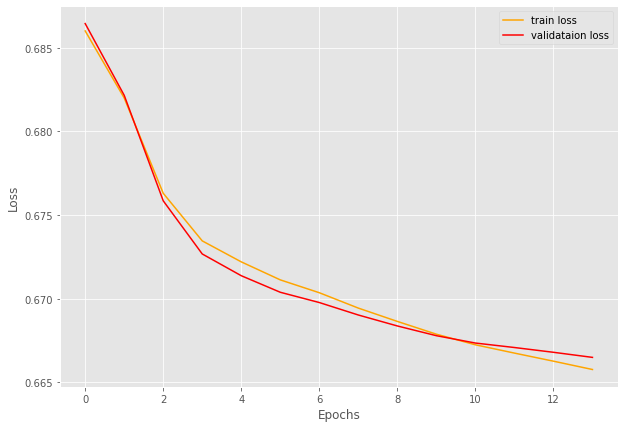

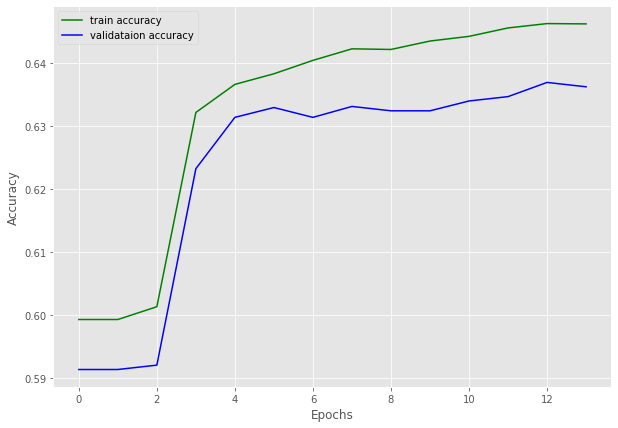

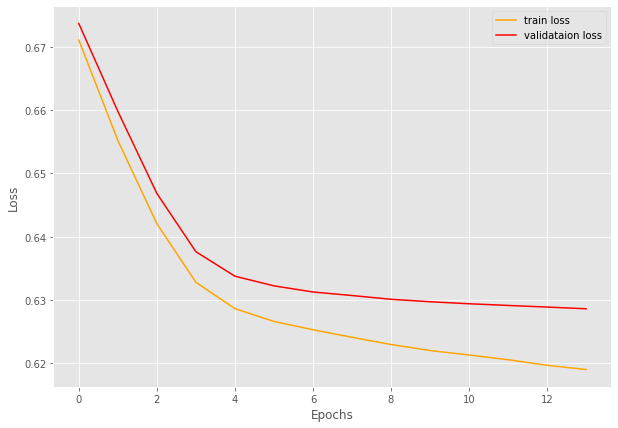

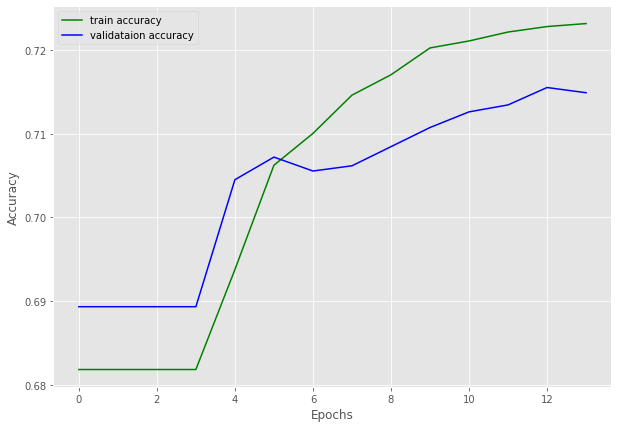

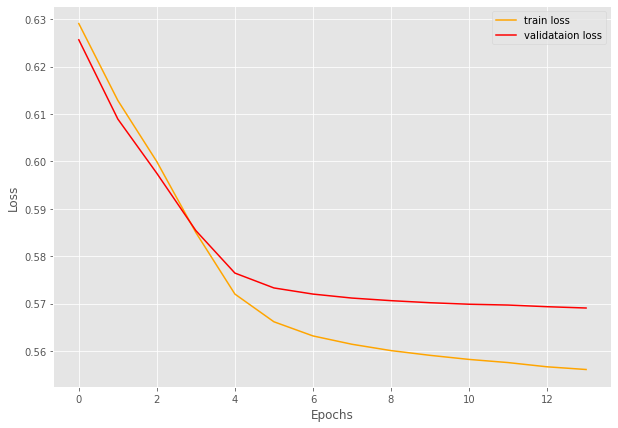

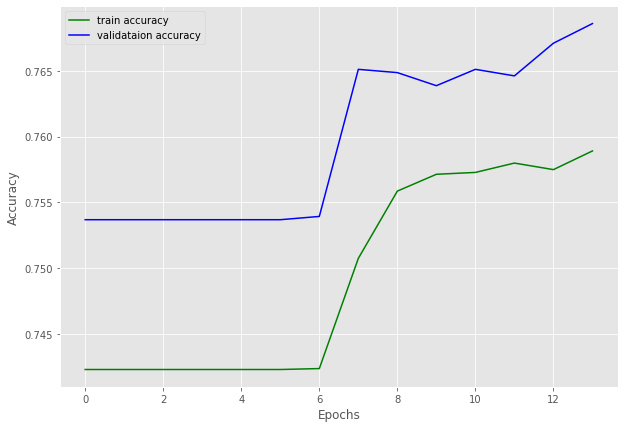

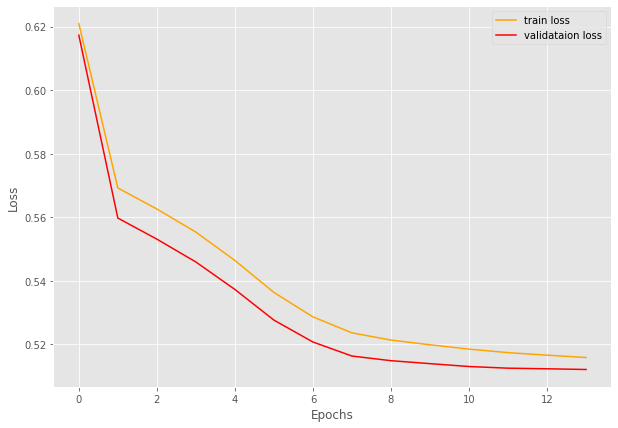

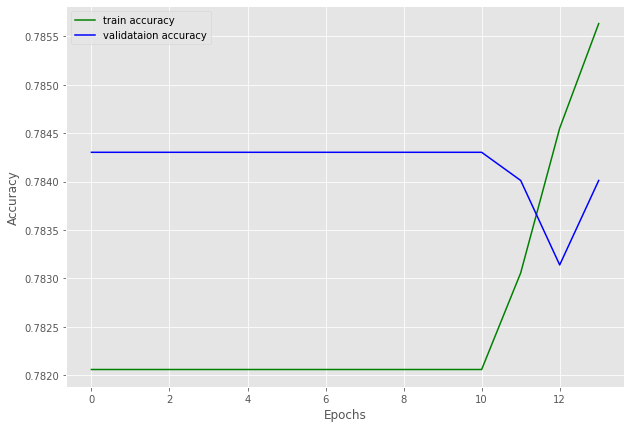

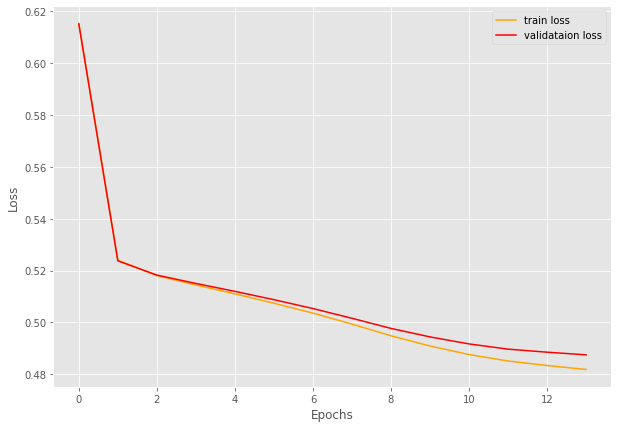

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)  
  param = {"lr": 0.00005, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_8
save Hyperparameter
Epoch: 001, Train Acc: 0.4549, Validation Acc: 0.4468, Loss Training: 0.6959, Loss Validation: 0.6963
Epoch: 002, Train Acc: 0.4549, Validation Acc: 0.4468, Loss Training: 0.6956, Loss Validation: 0.6959
Epoch: 003, Train Acc: 0.4549, Validation Acc: 0.4468, Loss Training: 0.6953, Loss Validation: 0.6956
Epoch: 004, Train Acc: 0.4549, Validation Acc: 0.4468, Loss Training: 0.6950, Loss Validation: 0.6953
Epoch: 005, Train Acc: 0.4550, Validation Acc: 0.4471, Loss Training: 0.6948, Loss Validation: 0.6950
Epoch: 006, Train Acc: 0.4550, Validation Acc: 0.4472, Loss Training: 0.6945, Loss Validation: 0.6948
Epoch: 007, Train Acc: 0.4565, Validation Acc: 0.4463, Loss Training: 0.6943, Loss Validation: 0.6945
Epoch: 008, Train Acc: 0.4593, Validation Acc: 0.4496, Loss Training: 0.6940, Loss Validation: 0.6942
Epoch: 009, Trai

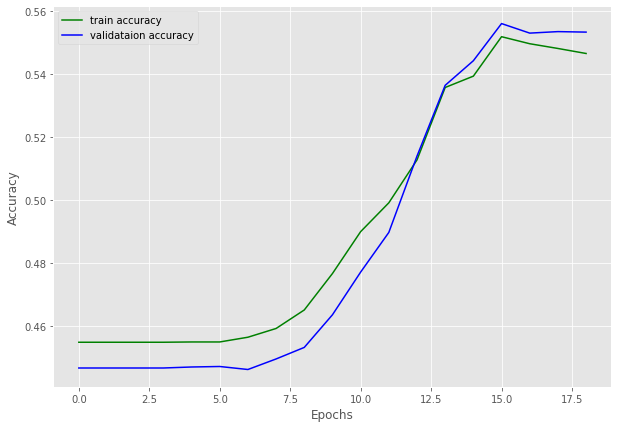

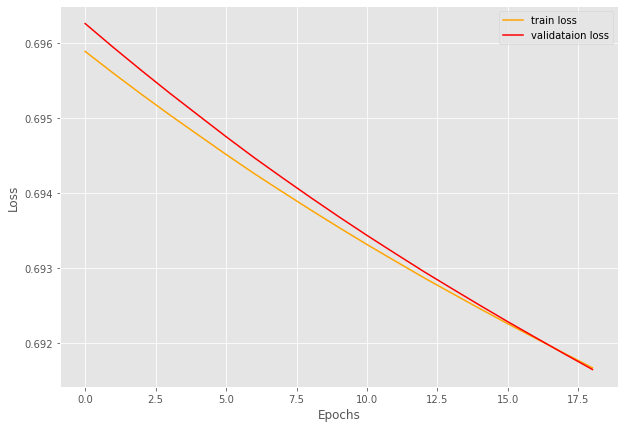

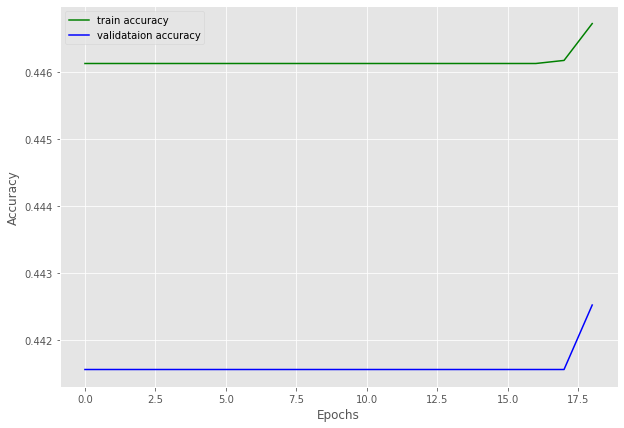

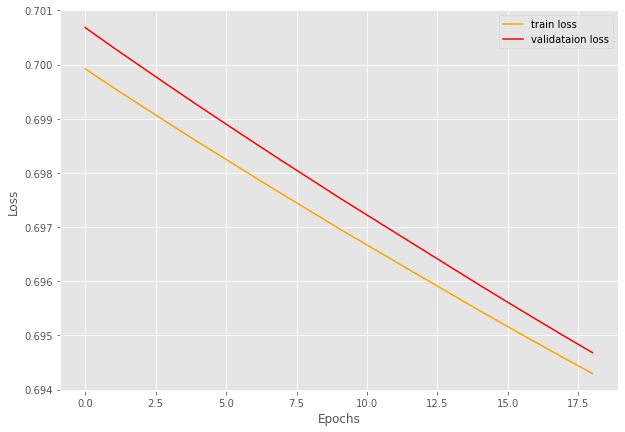

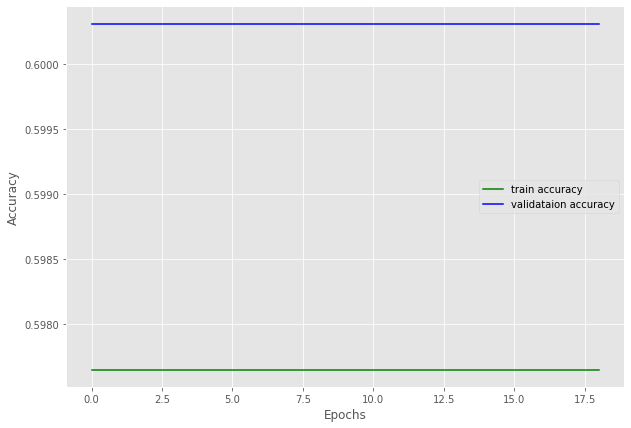

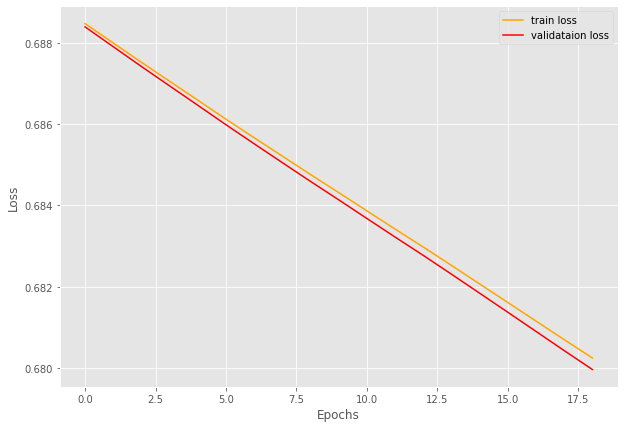

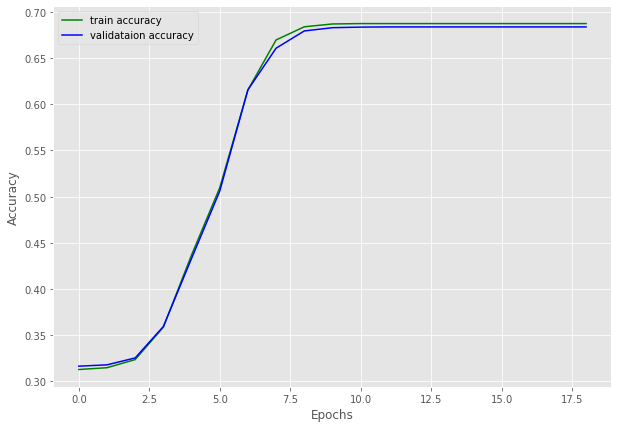

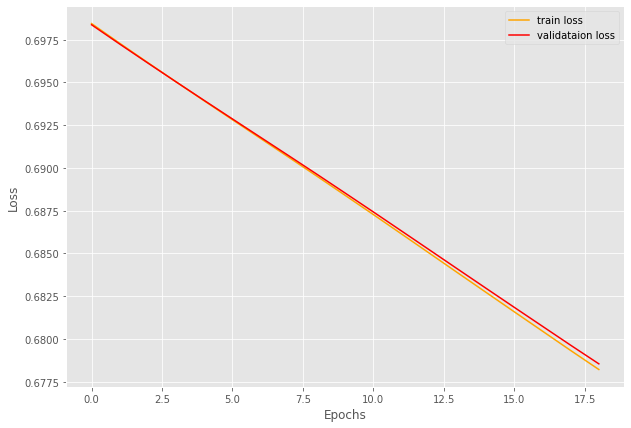

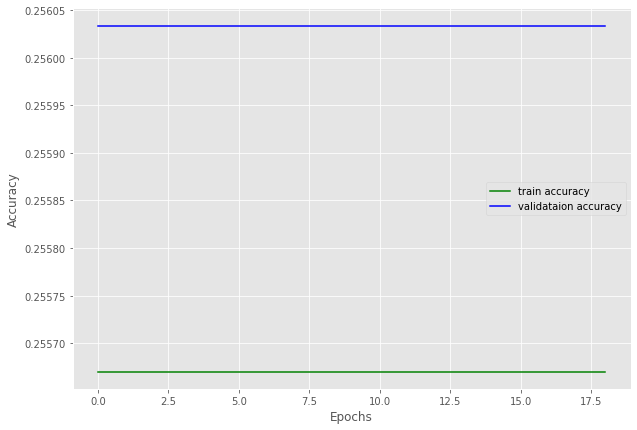

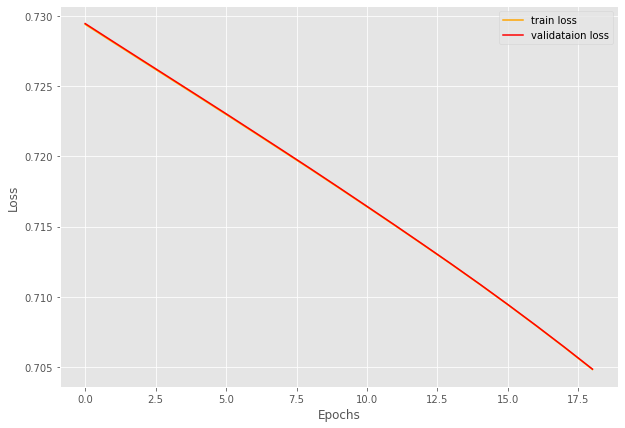

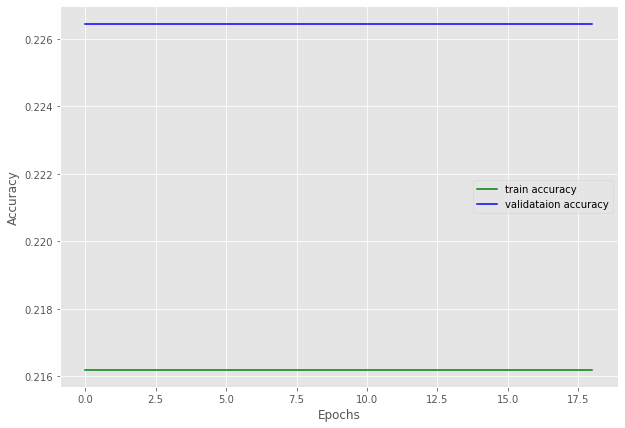

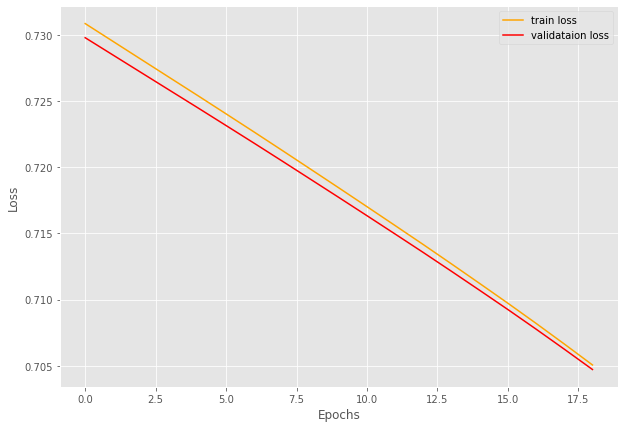

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)  
  param = {"lr": 0.000001, "num_epochs": 20}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/loan_all_events_fall_ohe_wEvents_5_2_4/run_9
save Hyperparameter
Epoch: 001, Train Acc: 0.4609, Validation Acc: 0.4727, Loss Training: 0.6944, Loss Validation: 0.6942
Epoch: 002, Train Acc: 0.5001, Validation Acc: 0.4931, Loss Training: 0.6930, Loss Validation: 0.6931
Epoch: 003, Train Acc: 0.5513, Validation Acc: 0.5365, Loss Training: 0.6916, Loss Validation: 0.6920
Epoch: 004, Train Acc: 0.5533, Validation Acc: 0.5384, Loss Training: 0.6903, Loss Validation: 0.6910
Epoch: 005, Train Acc: 0.5533, Validation Acc: 0.5384, Loss Training: 0.6891, Loss Validation: 0.6900
Epoch: 006, Train Acc: 0.5533, Validation Acc: 0.5384, Loss Training: 0.6878, Loss Validation: 0.6891
Epoch: 007, Train Acc: 0.5533, Validation Acc: 0.5384, Loss Training: 0.6866, Loss Validation: 0.6881
Epoch: 008, Train Acc: 0.5533, Validation Acc: 0.5384, Loss Training: 0.6855, Loss Validation: 0.6872
Epoch: 009, Trai

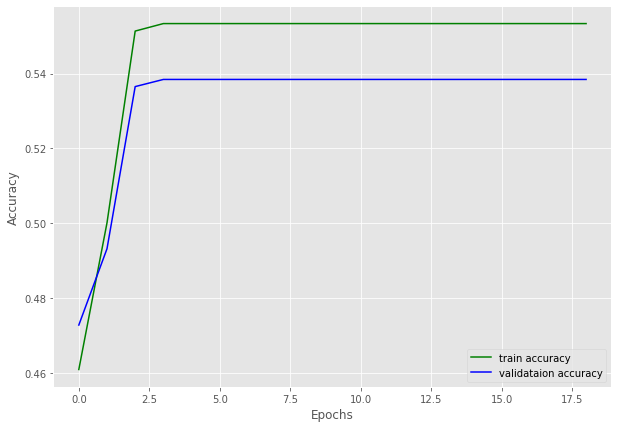

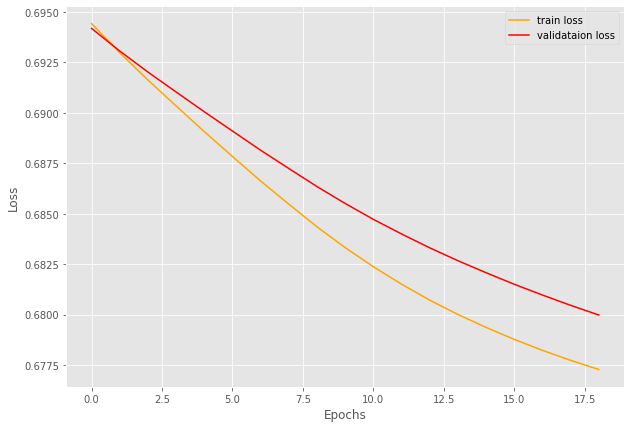

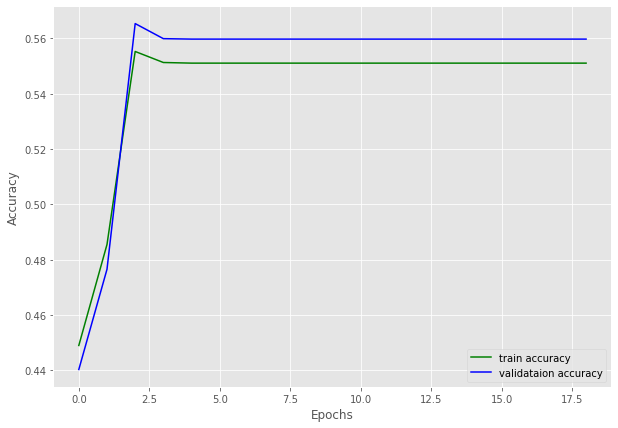

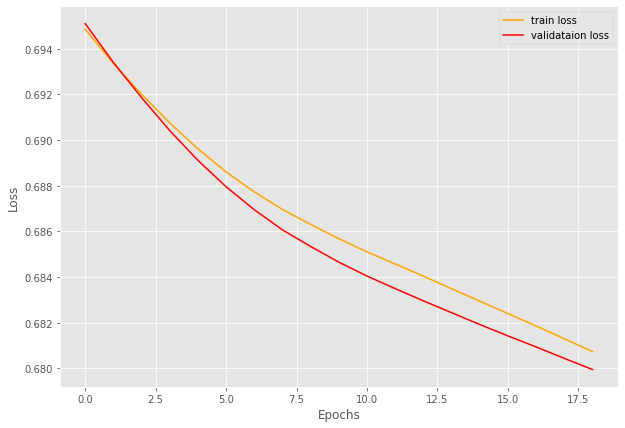

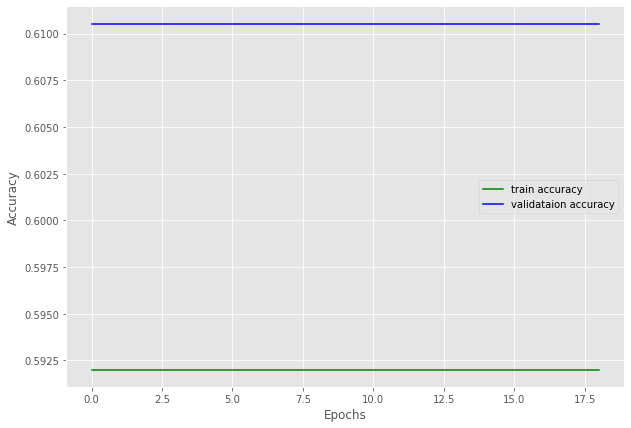

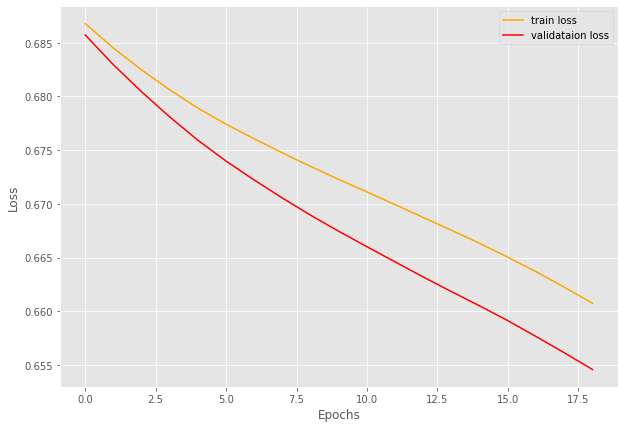

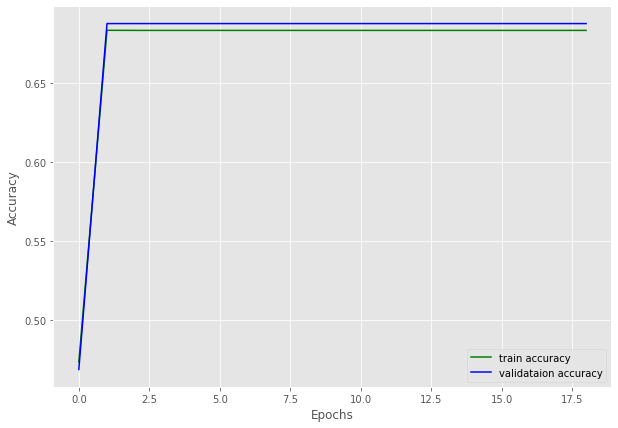

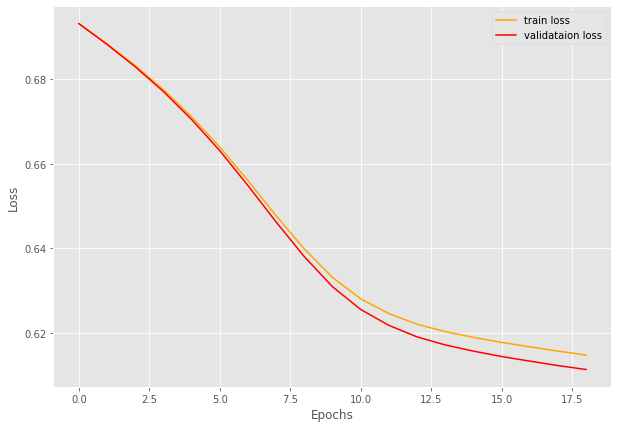

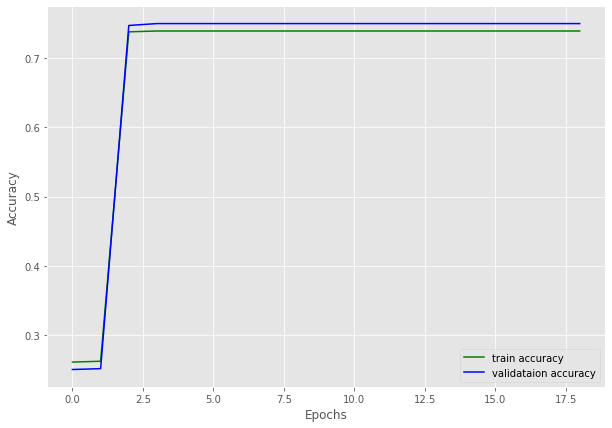

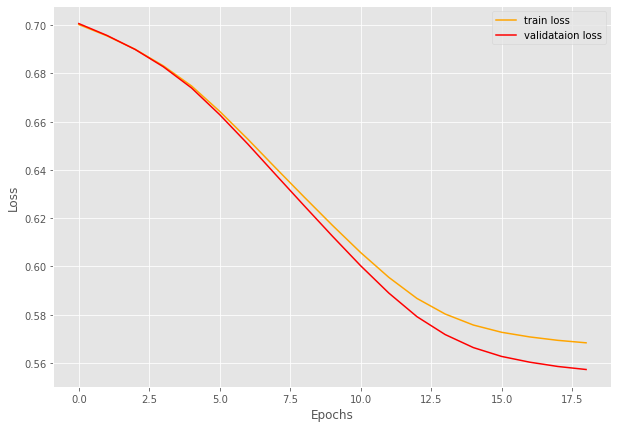

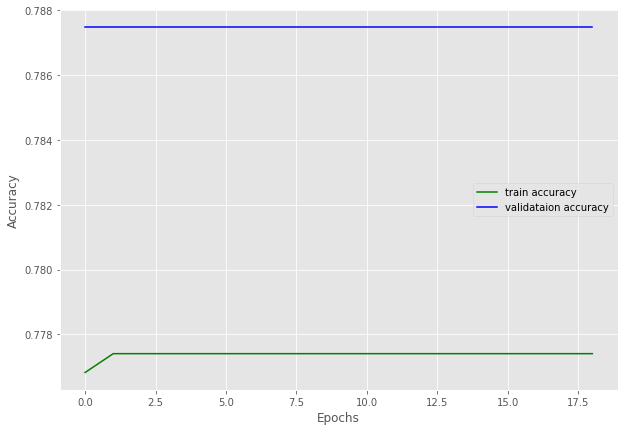

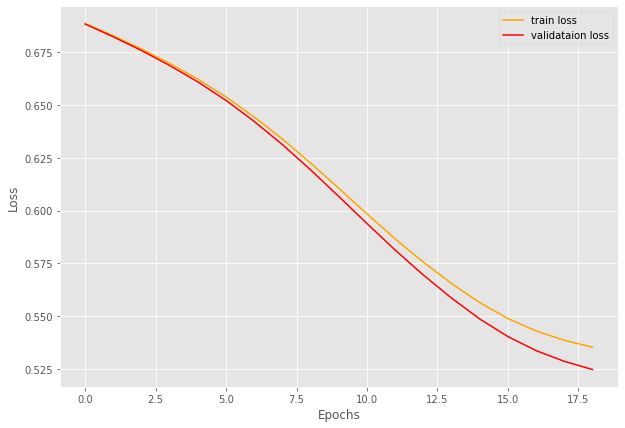

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(num_feature)  
  param = {"lr": 0.000005, "num_epochs": 20}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

## Training ausführen

In [ ]:
learning_rate = {
    0: 0.00005,
    4: 0.000001,
    7: 0.000005,
    10: 0.000005,
    13: 0.0001,
    16: 0.00005,
    19: 0.000005
}

num_epochs = {
    0: 300,
    4: 300,
    7: 300,
    10: 300,
    13: 100,
    16: 100,
    19: 300
}

In [ ]:
#num_epochs = 300
batch_size = 100
# learning_rate = 0.000001   # 0.001
# num_layer = 3
# hidden_channel = 100

### Länge 4

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 4
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)



<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
Epoch: 001, Train Acc: 0.4547, Validation Acc: 0.4522, Loss train: 0.6938918110999194, Loss val: 0.693865093919966
Epoch: 002, Train Acc: 0.4820, Validation Acc: 0.4831, Loss train: 0.6936447300694205, Loss val: 0.6936224859858316
Epoch: 003, Train Acc: 0.4953, Validation Acc: 0.4974, Loss train: 0.6934018511663783, Loss val: 0.6933840995743161
Epoch: 004, Train Acc: 0.5117, Validation Acc: 0.5147, Loss train: 0.6931679403240031, Loss val: 0.6931541458008781
Epoch: 005, Train Acc: 0.5243, Validation Acc: 0.5258, Loss train: 0.6929335507479581, Loss val: 0.6929241030935257
Epoch: 006, Train Acc: 0.5282, Validation Acc: 0.5312, Loss train: 0.6927083123813976, Loss val: 0.6927030256816319
Epoch: 007, Train Acc: 0.5370, Validation Acc: 0.5363, Loss train: 0.6924857432192022, Loss val: 0.6924842435216146
Epoch: 008, Train Acc: 0.5395, Validation Acc: 0.5349, Loss train: 0.6922684146599336, Loss val: 0.6922699288716392
Epoch: 009, Train Acc: 0.5484, Valid

###Länge 7

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 7
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)


<IPython.core.display.Javascript object>

-------------Präfix: 7--------------
Epoch: 001, Train Acc: 0.5116, Validation Acc: 0.5139, Loss train: 0.6929659108593039, Loss val: 0.6929606984532068
Epoch: 002, Train Acc: 0.5537, Validation Acc: 0.5475, Loss train: 0.6917488904304157, Loss val: 0.6918247843545581
Epoch: 003, Train Acc: 0.5538, Validation Acc: 0.5475, Loss train: 0.6906857577633095, Loss val: 0.6908367824932885
Epoch: 004, Train Acc: 0.5538, Validation Acc: 0.5475, Loss train: 0.6897463395715304, Loss val: 0.6899625781982665
Epoch: 005, Train Acc: 0.5538, Validation Acc: 0.5475, Loss train: 0.6889128167879636, Loss val: 0.6891884803771973
Epoch: 006, Train Acc: 0.5538, Validation Acc: 0.5475, Loss train: 0.6881499587128695, Loss val: 0.6884801974372258
Epoch: 007, Train Acc: 0.5538, Validation Acc: 0.5475, Loss train: 0.6874549816188202, Loss val: 0.6878321558710129
Epoch: 008, Train Acc: 0.5538, Validation Acc: 0.5475, Loss train: 0.6868055558095784, Loss val: 0.6872235347354223
Epoch: 009, Train Acc: 0.5538, Vali

###Länge 10

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 10
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 10--------------
Epoch: 001, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6872790637861919, Loss val: 0.6877425035526012
Epoch: 002, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6851270325078166, Loss val: 0.6857710624563282
Epoch: 003, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6830397092650089, Loss val: 0.6838839989283989
Epoch: 004, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6809495038586885, Loss val: 0.6820113011475267
Epoch: 005, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6789361306011971, Loss val: 0.6802202627576631
Epoch: 006, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6769851378619377, Loss val: 0.6785006708112257
Epoch: 007, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.6751499728028998, Loss val: 0.6768996253095824
Epoch: 008, Train Acc: 0.5997, Validation Acc: 0.5913, Loss train: 0.67343564338872, Loss val: 0.6754143803284086
Epoch: 009, Train Acc: 0.5997, Valid

###Länge 13

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 13
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

###Länge 16

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 16
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 16--------------
Epoch: 001, Train Acc: 0.7457, Validation Acc: 0.7310, Loss train: 0.6292803067687556, Loss val: 0.6329785178347331
Epoch: 002, Train Acc: 0.7457, Validation Acc: 0.7310, Loss train: 0.5603764617273993, Loss val: 0.5730018165053391
Epoch: 003, Train Acc: 0.7457, Validation Acc: 0.7310, Loss train: 0.5523541696528171, Loss val: 0.5647184732483654
Epoch: 004, Train Acc: 0.7457, Validation Acc: 0.7310, Loss train: 0.5440813241698218, Loss val: 0.5552976196858941
Epoch: 005, Train Acc: 0.7457, Validation Acc: 0.7310, Loss train: 0.5357831395264213, Loss val: 0.5461527974140353
Epoch: 006, Train Acc: 0.7457, Validation Acc: 0.7310, Loss train: 0.5281318259154651, Loss val: 0.5373251031084758
Epoch: 007, Train Acc: 0.7469, Validation Acc: 0.7328, Loss train: 0.5226124079092175, Loss val: 0.531284790940401
Epoch: 008, Train Acc: 0.7533, Validation Acc: 0.7430, Loss train: 0.5190437376921904, Loss val: 0.527096474316062
Epoch: 009, Train Acc: 0.7539, Valid

###Länge 19

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 19
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 19--------------
Epoch: 001, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6779428951996417, Loss val: 0.6783579877444676
Epoch: 002, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6718796388176848, Loss val: 0.6724711809839521
Epoch: 003, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6653353044809389, Loss val: 0.6661171351160322
Epoch: 004, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6580822797846203, Loss val: 0.6590780309268407
Epoch: 005, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6500320744908545, Loss val: 0.6512708783149719
Epoch: 006, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6406076087439356, Loss val: 0.6421317611421857
Epoch: 007, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6296452456269382, Loss val: 0.6315292937414987
Epoch: 008, Train Acc: 0.7816, Validation Acc: 0.7718, Loss train: 0.6176234252196698, Loss val: 0.6199422478675842
Epoch: 009, Train Acc: 0.7816, Val

###Ganzer Graph

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


#for key in dataset_list_review:
key = 0
print(f"-------------Präfix: {key}--------------")
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(num_feature)  
param = {"lr":learning_rate[key], "epochs": num_epochs[key]}
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 0--------------
Epoch: 001, Train Acc: 0.5522, Validation Acc: 0.5422, Loss train: 0.6708903250369158, Loss val: 0.672068697119516
Epoch: 002, Train Acc: 0.8084, Validation Acc: 0.8106, Loss train: 0.46057270927862687, Loss val: 0.46043924064863295
Epoch: 003, Train Acc: 0.8140, Validation Acc: 0.8160, Loss train: 0.400009575215253, Loss val: 0.39822340058901956
Epoch: 004, Train Acc: 0.8258, Validation Acc: 0.8270, Loss train: 0.377957364984534, Loss val: 0.3762351818501003
Epoch: 005, Train Acc: 0.8388, Validation Acc: 0.8391, Loss train: 0.3603113467720422, Loss val: 0.35844378338919747
Epoch: 006, Train Acc: 0.8457, Validation Acc: 0.8461, Loss train: 0.3473255160180005, Loss val: 0.34607216786770595
Epoch: 007, Train Acc: 0.8518, Validation Acc: 0.8515, Loss train: 0.33840937743132765, Loss val: 0.33725063289914814
Epoch: 008, Train Acc: 0.8558, Validation Acc: 0.8534, Loss train: 0.33286668624390253, Loss val: 0.33177452877400415
Epoch: 009, Train Acc: 0.8580

## Alt

## Training visualisieren

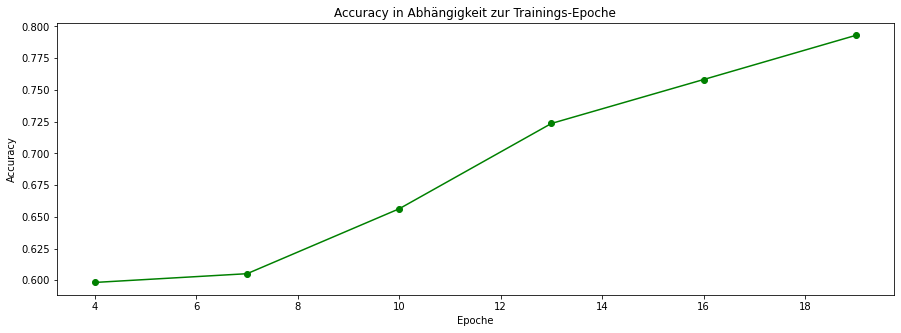

In [ ]:
import matplotlib.pyplot as plt

# number of employees of A
acc_gcn = [loan_results[x][1][-1][1] for x in loan_results]
#acc_ggnn = [x[3] for x in train_results_ggnn]
#pre = [x for x in range(1, num_epochs)]
pre = [k for k in dataset_list_review]
fig = plt.figure(figsize=(15, 5))

# plot a line chart
plt.plot(pre[:-1], acc_gcn[:-1], 'o-g')
#plt.plot(epochs[:50], acc_ggnn[:50], 'o-r')
# plt.plot(epochs, fidelity_inv_values, 'o-b')

# set axis titles
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
# set chart title
plt.title(f"Accuracy in Abhängigkeit zur Trainings-Epoche")
#plt.legend(['Fidelity+', 'Fidelity-'])
plt.show()

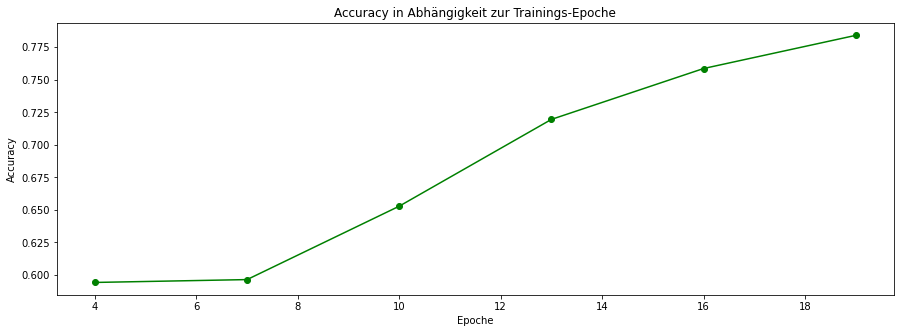

In [ ]:
import matplotlib.pyplot as plt

# number of employees of A
acc_gcn = [loan_results[x][0][-1][1] for x in loan_results]
#acc_ggnn = [x[3] for x in train_results_ggnn]
#pre = [x for x in range(1, num_epochs)]
pre = [k for k in dataset_list_review]
fig = plt.figure(figsize=(15, 5))

# plot a line chart
plt.plot(pre[:-1], acc_gcn[:-1], 'o-g')
#plt.plot(epochs[:50], acc_ggnn[:50], 'o-r')
# plt.plot(epochs, fidelity_inv_values, 'o-b')

# set axis titles
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
# set chart title
plt.title(f"Accuracy in Abhängigkeit zur Trainings-Epoche")
#plt.legend(['Fidelity+', 'Fidelity-'])
plt.show()

In [ ]:
data = dataset_list_review[10][0]

In [ ]:
norm_cols = ['Request_Amount', 'Time_Bevor_Event']
node_feature = feature_list_review[10][len(norm_cols):]
#node_feature

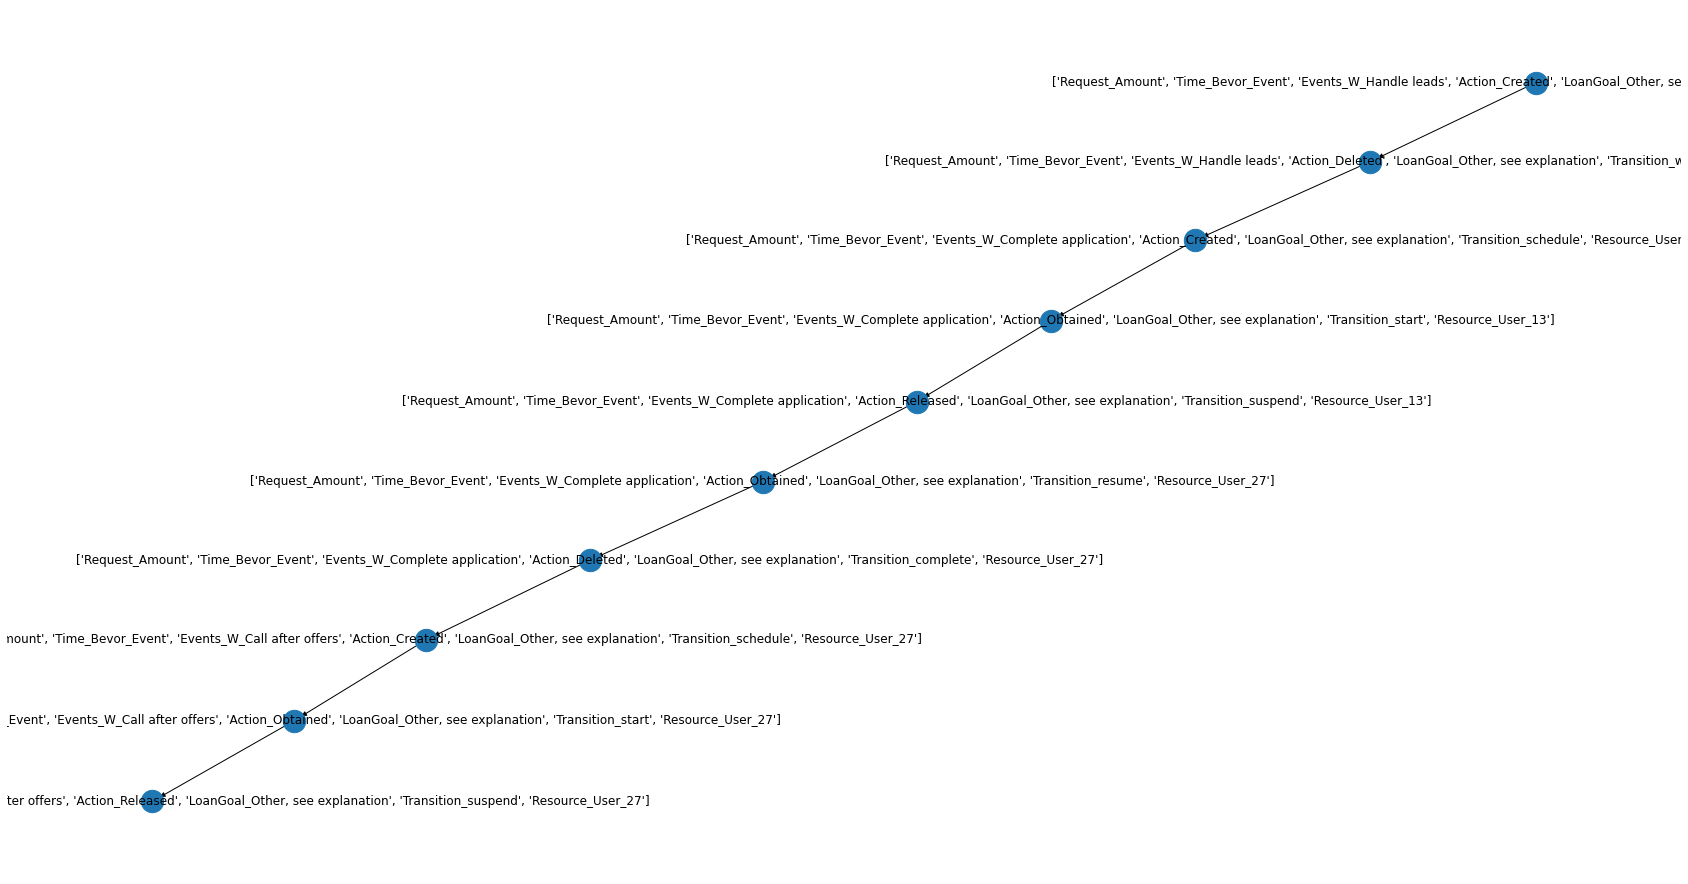

In [ ]:
from torch_geometric.utils import to_networkx

''' Visualisierung einer Graphen-Instanz mit Knoten-Featurn'''
# self.data = data
# dic_encoder = self.dic_encoder 
# scaler = self.scaler 

# Netzwerkx Objekt erstellen
G = to_networkx(data)

# Array aller Knoten erstellen
if data.num_features > 1:
    nodes = data.x.squeeze(1).tolist()
else:
    nodes = data.x.tolist()

# Normalisierung Rückgängig machen und Node-Werte von float zu int transformieren
# if scaler != None:
#     nodes = scaler.inverse_transform(nodes)
#     nodes = np.around(np.array(nodes))
# else:
#   nodes = [int(x) for x in nodes]                                        

# Encoder 
# encoder_name = d['event_name']
# encoder_transition = d["transition"]
# encoder_result = d["result"]
# encoder_timestamp = d["timestamp"]

# Encoding Rückgängig machen
codes = []
# Label-Encoding

# One-Hot-Encoder, Namen durch Multiplikation mit Feature-Vector erhalten
n_labels = get_labels_ohe(nodes, node_feature)

# Wenn kein Encoder übergeben wurde, werden die Nummern zur graphischen Darstellung verwendet            
# n_labels = {}
# for n_id, node in enumerate(nodes):
#     n_labels[n_id] = node


# Darstellen des Netzwerks
pos = nx.kamada_kawai_layout(G)  
fig = plt.figure(figsize=(30, 16))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, arrows = True )
nx.draw_networkx_labels(G,pos, labels=n_labels)
plt.show()

In [ ]:
def get_labels_ohe(nodes, node_features):   
      
        n_labels = {}
        for n_id, node in enumerate(nodes):
            # Float zu Int transformieren
            node = list(map(int, node))
            node = node[len(norm_cols):]
            # Erhalten der Benennungen durch Multiplizieren der node_feature-Liste mit der Encoded node-Liste. 
            # Durch OHE ist Wert eines Features [1,0]. Ergebnis ist eine Liste aller Feature. Output: {node_id: [feature]}
            n_labels[n_id] = norm_cols + sum([[s] * n for s, n in zip(node_features, node)], [])
        return  n_labels